### Курсовая работа
**Вариант №6**

Задание: Даны два набора данных, размеченный и неразмеченный, содержащие многомерную телеметрическую информацию малого космического аппарата.
* Нужно сделать из исходного набора данных, преобразованный исходный набор данных и выполнить для этих наборов разведочный анализ.
* Выполнить проверку исходного размеченного набора данных на сбалансированность классов.
* Для комбинации набора данных и предиктивной модели выполнить поиск гиперпараметров с помощью генетического алгоритма. Сохраняя лог всех генерируемых НС моделей в популяции.
* На неразмеченной части набора данных выполнить предобучение с помощью автокодировщика, построенного на основании базового нейросетевого классификатора, заданного в варианте.
* Выполнить точную настройку (дообучение) базовой нейронной сети на размеченном наборе данных.
* Предиктивная модель (нейросетевой классификатор) по заданию - это Ансамбль нейронных сетей типа бэггинг на основе рекуррентной GRU нейросетевой модели с полносвязным классификатором.

Алгоритм выполнения задания:
1) Загрузка данных, разведочный анализ исходного набора данных.
2) Алгоритмический отбор наиболее важных признаков для формирования преобразованного исходного набора.
3) Разведочный анализ преобразованного исходного набора.
4) Проверка набора данных на сбалансированность классов.
5) Поиск оптимальной архитектуры CNN-GRU нейронной сети с помощью генетического алгоритма.
7) Построение автокодировщика на основе лучшей CNN-GRU архитектуры.
8) Создание ансамбля бэггинг на основе предобученного автокодировщика.

Производим импорт необходимых библиотек.

In [20]:
import os
import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report, 
    balanced_accuracy_score, 
    accuracy_score, 
    roc_auc_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import entropy, chisquare
import tensorflow as tf
from tensorflow.keras import layers
from deap import base, creator, tools, algorithms

# Suppress warnings and logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

##### 1. Загрузка и подготовка исходного и преобразованного наборов данных

In [21]:
# Загрузка данных
data_labeled = pd.read_excel("MKA_TMI_Labels.xls", header=None)
data_unlabeled = pd.read_csv("MKA_04.2015_unlabeled.csv", header=None)

data_original = data_labeled.copy()
data_transformed = data_labeled.copy()

В данном блоке загружаются исходные данные из файлов (MKA_TMI_Labels.xls и MKA_04.2015_unlabeled.csv). Создаются две основные переменные: data_original (копия размеченных данных без изменений) и data_transformed (будущий преобразованный исходный набор).
В переменные загружены данные в формате DataFrame для последующего анализа и преобразований.

##### 2. Разведочный анализ данных
Ознакомимся с набором данных методами описательной статистики, выведем первые несуколько строк, посмотрим набор столбцов и типы данных, проверим их на полноту (чтобы не было строк с незаполненными ячейками), оценим статистические характеристики числовых полей.

In [22]:
# 2.1. Вывод размерности набора данных
print("\n2.1. Размерность набора данных:")
print(f"Количество строк: {data_original.shape[0]}")
print(f"Количество столбцов: {data_original.shape[1]}")

# 2.2. Вывод типов данных для каждой из колонок
print("\n2.2. Типы данных для каждой из колонок:")
print(data_original.dtypes)

# 2.3. Вывод первых 5 строчек для визуального осмотра характера данных
print("\n2.3. Первые 5 строк набора данных:")
print(data_original.head())

# 2.4. Вывод сводной информации о наборе данных
print("\n2.4. Сводная информация о наборе данных:")
data_original.info()

# 2.5. Вывод базовых статистических данных по полям, в том числе и количество значений, среднее, минимумы-максимумы
print("\n2.5. Базовые статистические данные по полям:")
print(data_original.describe())


2.1. Размерность набора данных:
Количество строк: 2680
Количество столбцов: 50

2.2. Типы данных для каждой из колонок:
0     object
1     object
2     object
3     object
4     object
5     object
6     object
7     object
8     object
9     object
10    object
11    object
12    object
13    object
14    object
15    object
16    object
17    object
18    object
19    object
20    object
21    object
22    object
23    object
24    object
25    object
26    object
27    object
28    object
29    object
30    object
31    object
32    object
33    object
34    object
35    object
36    object
37    object
38    object
39    object
40    object
41    object
42    object
43    object
44    object
45    object
46    object
47    object
48    object
49    object
dtype: object

2.3. Первые 5 строк набора данных:
      0      1       2       3       4       5       6       7       8       9        10       11       12       13       14       15       16       17     18     19     20     21

В данном блоке проводится первичный анализ исходных данных. Это включает в себя:
Изучение размерности данных (количество строк и столбцов).
Определение типов данных в каждом столбце.
Просмотр первых строк для понимания структуры.
Итог анализа массива данных: параметры представляют собой объекты, необходимо привести их числовой вид для дальнейшей работы.

##### 2.6 Оцифровка данных исходного набора в числовые типы 

In [23]:
# 2.6. Оцифровка данных исходного набора в числовые типы
# Переименовываем заголовки
data_original = data_original.rename(columns=data_original.iloc[0]).drop(0).reset_index(drop=True)
print("\n2.6. Первые 5 строк набора данных после изменения названия столбцов:")
print(data_original.head())

# Преобразуем все данные в строки перед заменой (чтобы .str работал)
data_original = data_original.astype(str)

# Меняем запятые на точки во всех столбцах для конвертации в тип данных float
for col in data_original.columns:
    data_original[col] = data_original[col].str.replace(',', '.', regex=False)

# Конвертируем все столбцы в float 
for col in data_original.columns:
    data_original[col] = data_original[col].astype(float)

print("Данные преобразованы в числовые типы. Типы столбцов после оцифровки:")
print(data_original.dtypes)
print("\nПервые 5 строк набора данных после оцифровки:")
print(data_original.head())

# Копируем оцифрованный data_original в data_transformed для дальнейших действий
data_transformed = data_original.copy()


# 2.6.1. Оцифровка данных массива data_unlabeled в числовые типы (аналогично data_original)
# Переименовываем заголовки (берем первую строку как названия столбцов)
data_unlabeled = data_unlabeled.rename(columns=data_unlabeled.iloc[0]).drop(0).reset_index(drop=True)
print("\n2.6.1. Первые 5 строк набора data_unlabeled после изменения названия столбцов:")
print(data_unlabeled.head())

# Преобразуем все данные в строки перед заменой (чтобы .str работал)
data_unlabeled = data_unlabeled.astype(str)
# Меняем запятые на точки во всех столбцах для конвертации в тип данных float
for col in data_unlabeled.columns:
    data_unlabeled[col] = data_unlabeled[col].str.replace(',', '.', regex=False)
# Конвертируем все столбцы в float 
for col in data_unlabeled.columns:
    data_unlabeled[col] = data_unlabeled[col].astype(float)

print("\nДанные data_unlabeled преобразованы в числовые типы. Типы столбцов после оцифровки:")
print(data_unlabeled.dtypes)
print("\nПервые 5 строк набора data_unlabeled после оцифровки:")
print(data_unlabeled.head())




2.6. Первые 5 строк набора данных после изменения названия столбцов:
   Ubs,V Ibs,A Isun,A Ipt1,A Ipt2,A Ipt3,A Ipt4,A Ipt5,A Ipt6,A Ipt7,A Ipt10,A Ipt11,A Ipt12,A Ipt13,A Ipt14,A Ipt15,A Ipt16,A Ipt17,A TR1,C TR2,C TR3,C TR4,C TR5,C TR6,C TR7,C TR8,C TR9,C TR10,C TR11,C TR12,C TR13,C TR14,C TR15,C TR16,C TDS1,C TDS2,C TDS3,C TDS4,C TDS5,C TDS6,C TDS7,C TDS8,C TDS9,C TKpt,C TGbv,C TNap,C TPrd2,C TPrd1,C TDS24,C Class
0  14.83  0.24   0.91   0.09   0.07      0      0      0      0      0       0       0       0       0       0       0       0       0    21    19    16    14     6     8    14    17    13     11     25      9     17     19     18     19     18     18     18     18     18     18     17     17     17     25     17     16      18      18      21     0
1  14.76  0.21   0.27   0.07   0.07      0      0      0      0      0       0       0       0       0       0       0       0       0    21    20    16    15     6     8    14    17    13     12     25      9     17     20   

В этом блоке кода данные, которые могли быть загружены как строки (из-за запятых в качестве десятичных разделителей), преобразуются в числовой формат (float).
Потому что нейронные сети и большинство алгоритмов ML работают с числовыми данными. Запуск программы с объектами приводит к ошибке. Этот шаг необходим для дальнейшей работы с данными применительно к машинному обучению.
Pandas преобразует объекты в числа (строковые операции .str.replace(), преобразование типов .astype()). Запятые заменяются на точки во всех столбцах, после чего весь DataFrame преобразуется в тип float. Процесс применяется как к data_original, так и к data_unlabeled.

 ##### 2.7 Полный разведочный анализ исходного размеченного набора данных.
 Полный разведочный анализ для оригинального набора данных после оцифровки.


2.7. Размерность набора данных (data_original):
Количество строк: 2679
Количество столбцов: 50

2.8. Типы данных для каждой из колонок (data_original):
Ubs,V      float64
Ibs,A      float64
Isun,A     float64
Ipt1,A     float64
Ipt2,A     float64
Ipt3,A     float64
Ipt4,A     float64
Ipt5,A     float64
Ipt6,A     float64
Ipt7,A     float64
Ipt10,A    float64
Ipt11,A    float64
Ipt12,A    float64
Ipt13,A    float64
Ipt14,A    float64
Ipt15,A    float64
Ipt16,A    float64
Ipt17,A    float64
TR1,C      float64
TR2,C      float64
TR3,C      float64
TR4,C      float64
TR5,C      float64
TR6,C      float64
TR7,C      float64
TR8,C      float64
TR9,C      float64
TR10,C     float64
TR11,C     float64
TR12,C     float64
TR13,C     float64
TR14,C     float64
TR15,C     float64
TR16,C     float64
TDS1,C     float64
TDS2,C     float64
TDS3,C     float64
TDS4,C     float64
TDS5,C     float64
TDS6,C     float64
TDS7,C     float64
TDS8,C     float64
TDS9,C     float64
TKpt,C     float64
TGbv,C     

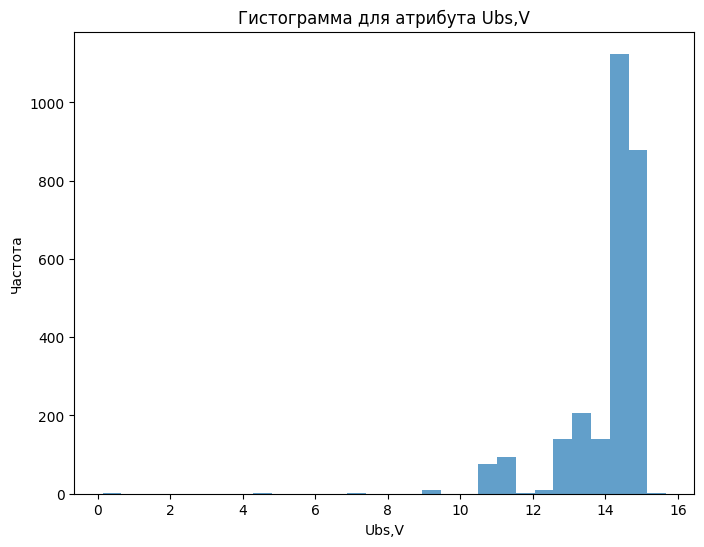

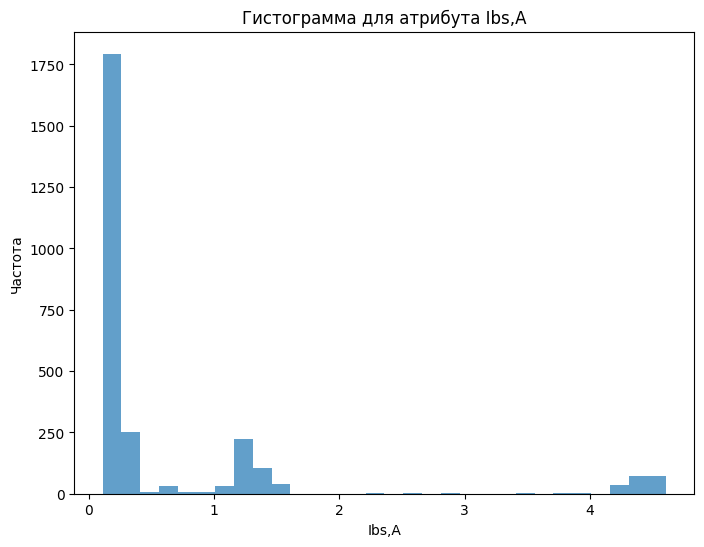

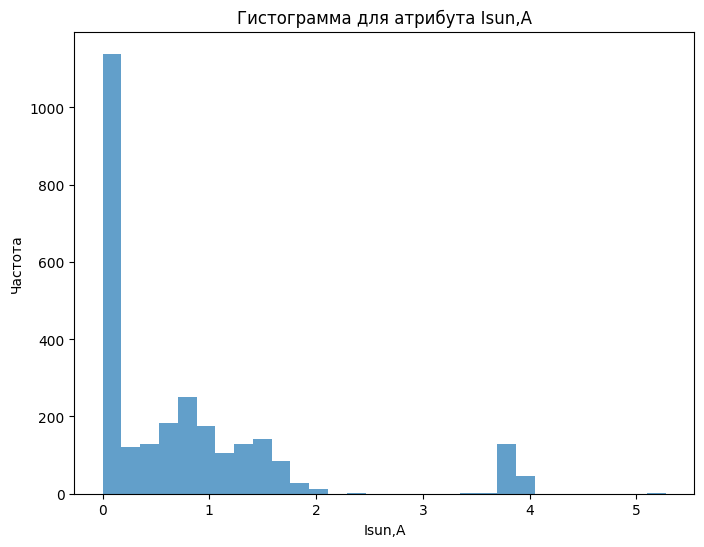

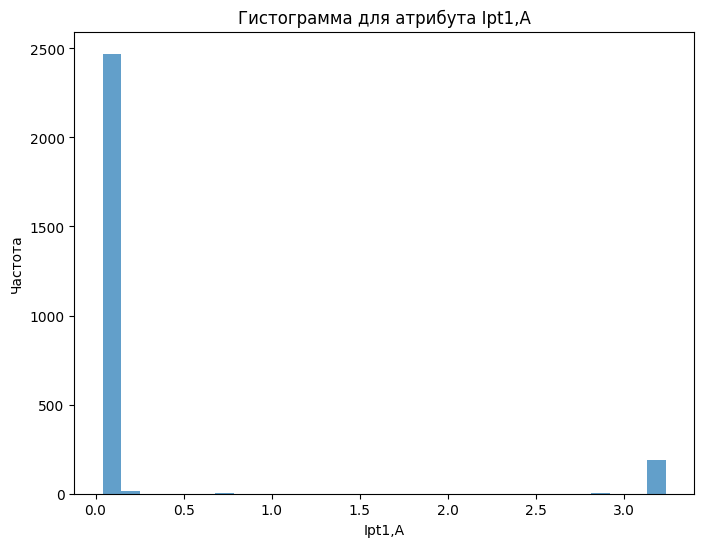

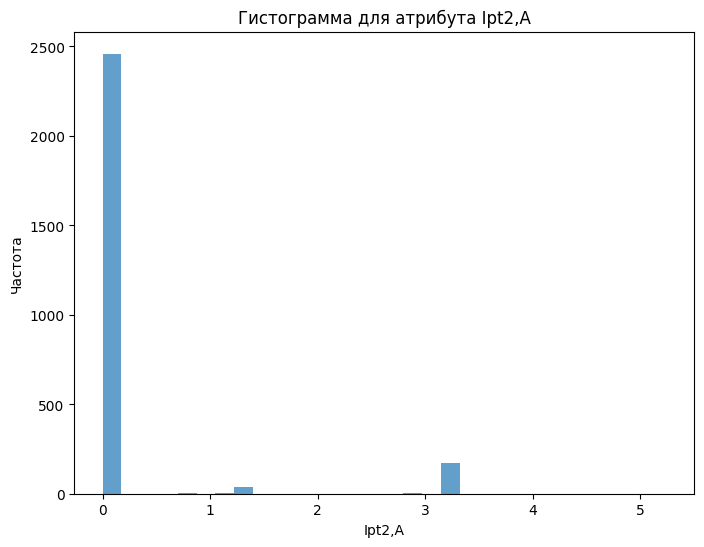


2.14.1 Графики плотности для признаков (data_original, первые 5):


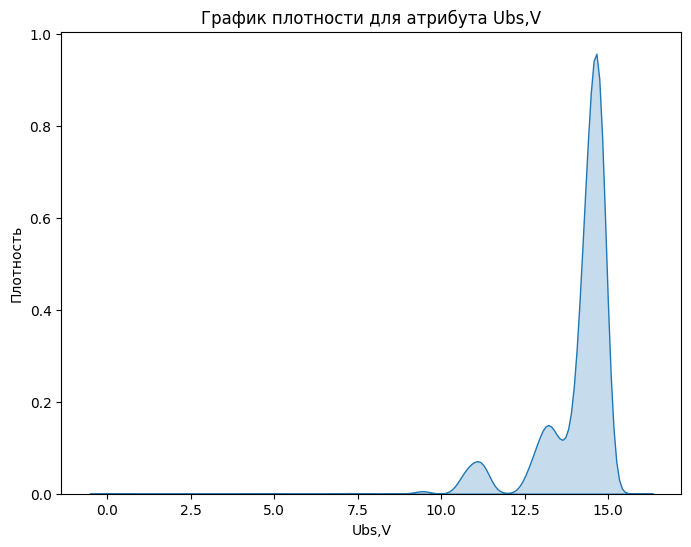

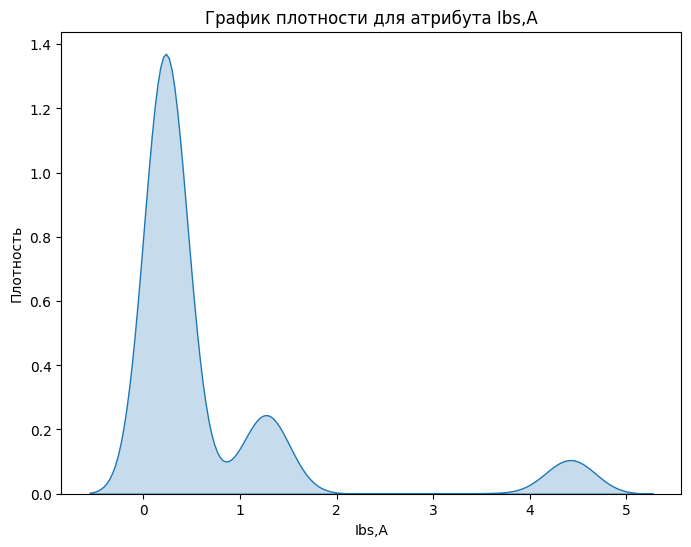

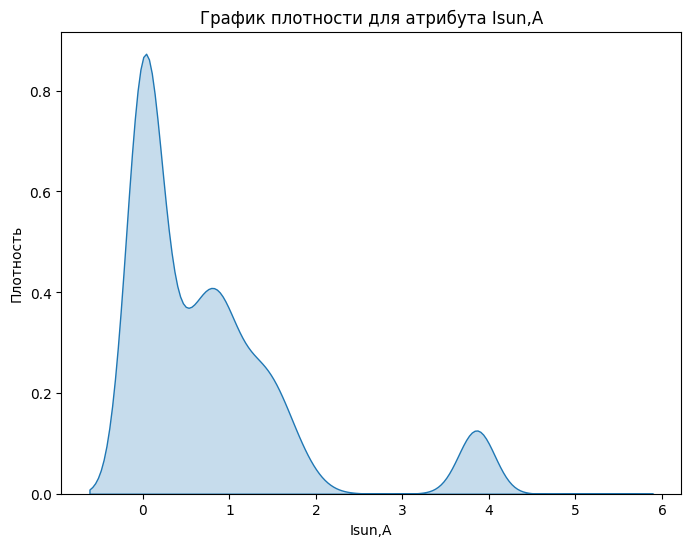

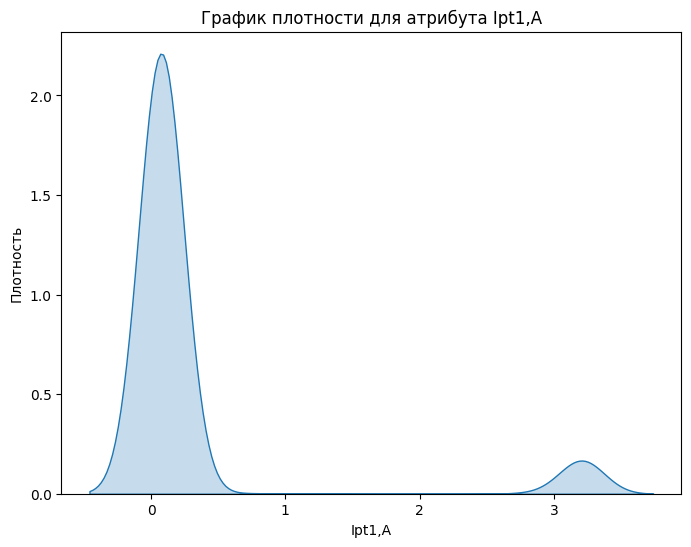

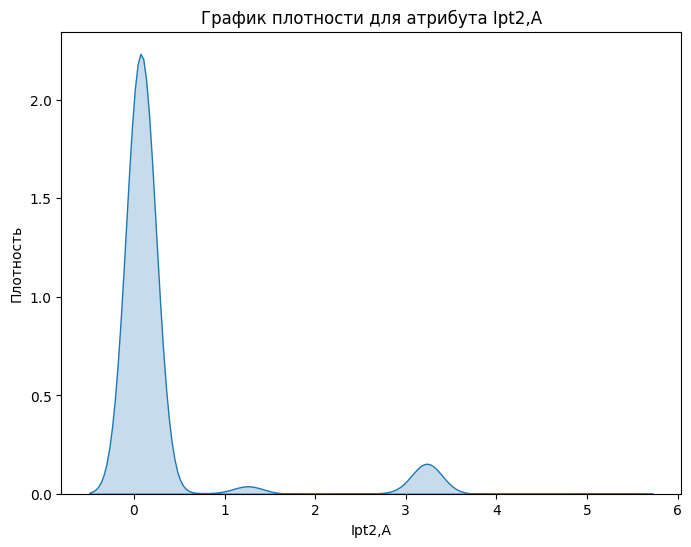


2.15. Корреляционная матрица (data_original):


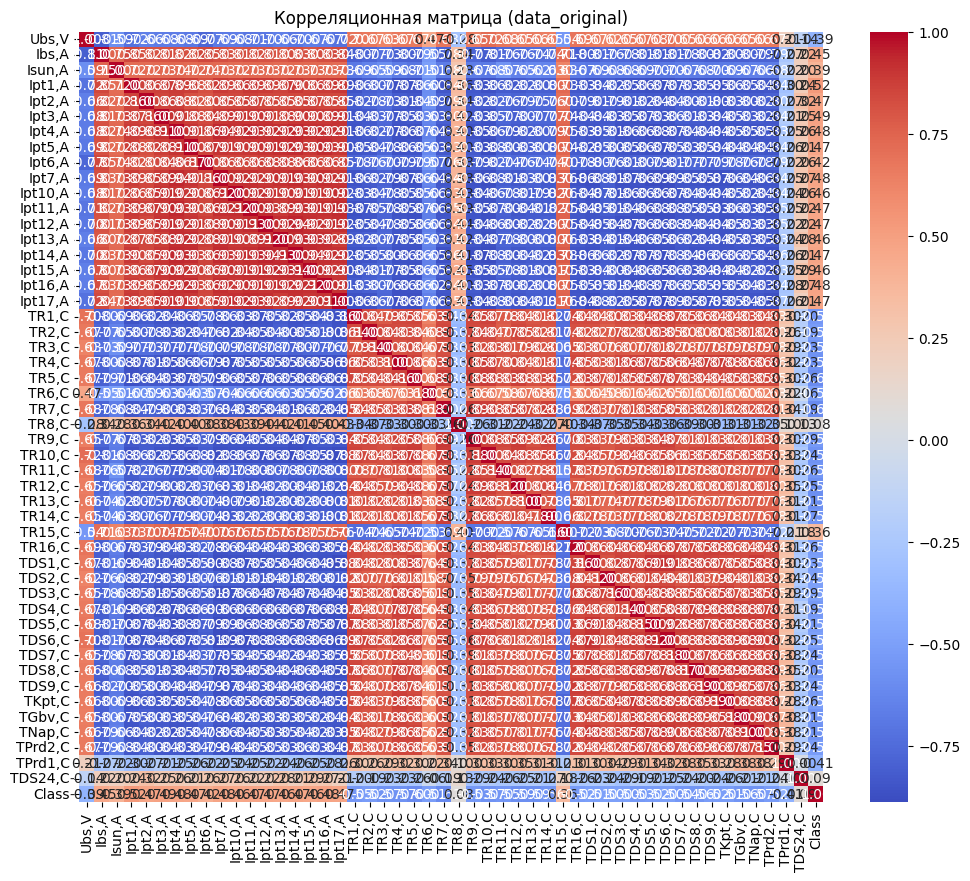


2.16.1 Матрица диаграммы рассеяния (data_original, первые 5 признаков):


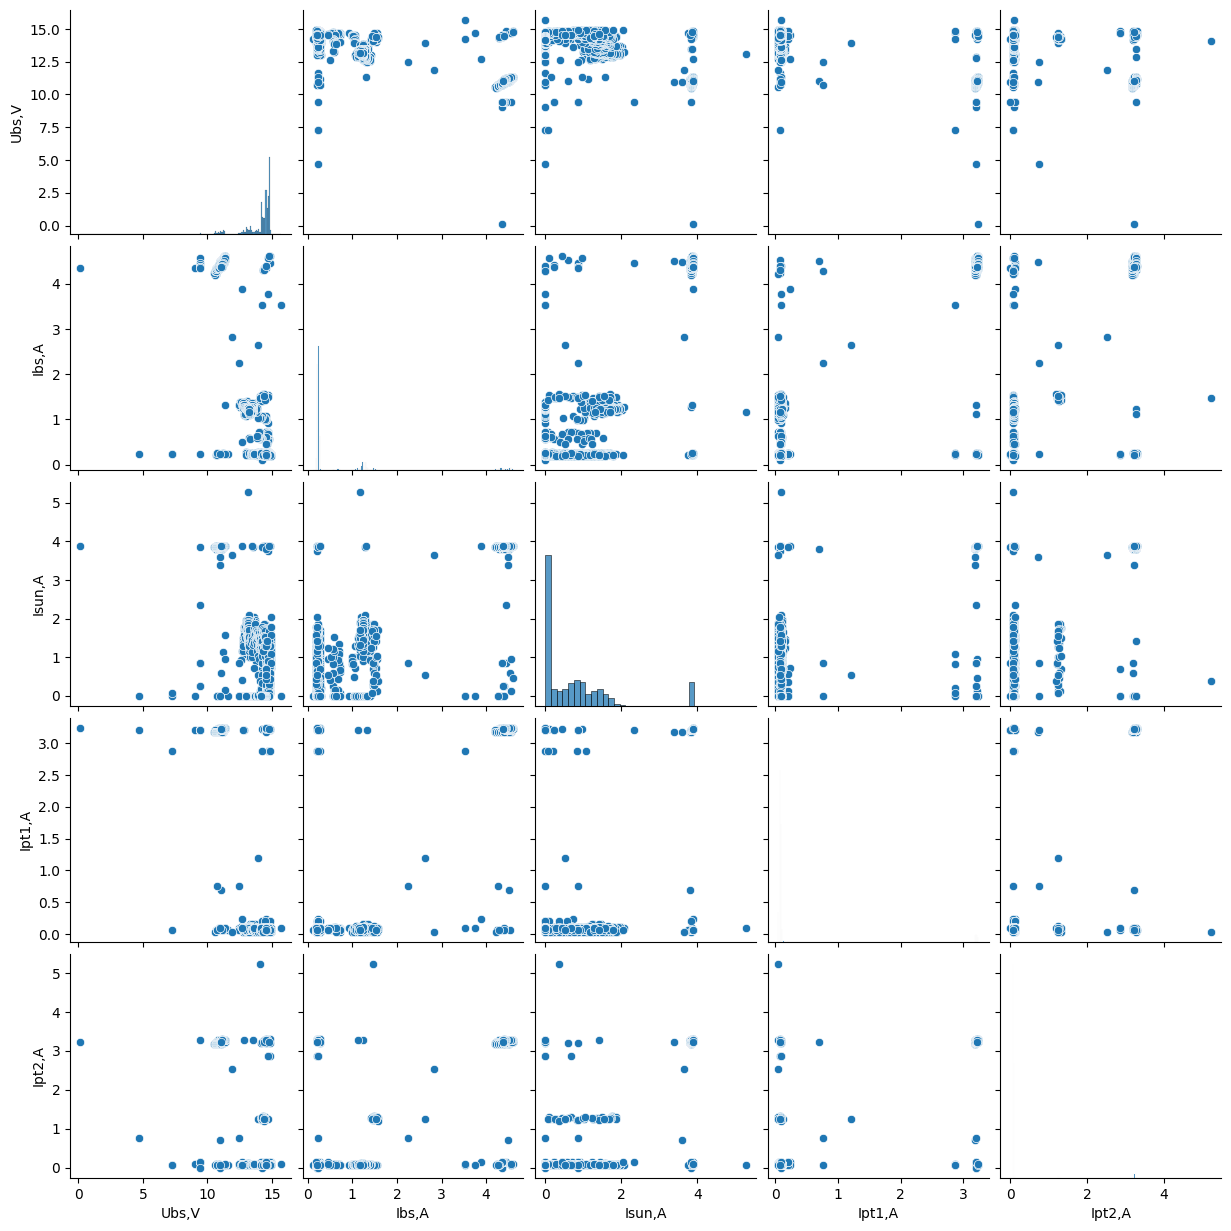

In [24]:
# 2.7. Вывод размерности набора данных
print("\n2.7. Размерность набора данных (data_original):")
print(f"Количество строк: {data_original.shape[0]}")
print(f"Количество столбцов: {data_original.shape[1]}")

# 2.8. Вывод типов данных для каждой из колонок
print("\n2.8. Типы данных для каждой из колонок (data_original):")
print(data_original.dtypes)

# 2.9. Вывод первых 5 строчек для визуального осмотра характера данных
print("\n2.9. Первые 5 строк набора данных (data_original):")
print(data_original.head())

# 2.10. Вывод сводной информации о наборе данных
print("\n2.10. Сводная информация о наборе данных (data_original):")
print(data_original.info())

# 2.11. Вывод базовых статистических данных по полям
print("\n2.11. Базовые статистические данные по полям (data_original):")
print(data_original.describe())

# 2.12. Проверка на пропуски и выбросы
print("\n2.12. Проверка на пропуски (data_original):")
missing_values = data_original.isnull().sum()
print(missing_values[missing_values > 0])  # Только если есть
if missing_values.sum() == 0:
    print("Пропусков нет.")

# 2.13.1 Гистограммы для признаков (пример для первых 5 признаков)
print("\n2.13.1 Гистограммы для признаков (data_original, первые 5):")
features_to_plot = list(data_original.columns)[:5] if len(data_original.columns) > 5 else list(data_original.columns)
for col in features_to_plot:
    plt.figure(figsize=(8, 6))
    plt.hist(data_original[col], bins=30, alpha=0.7)
    plt.title(f'Гистограмма для атрибута {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.show()

# 2.13.2 Гистограммы для признаков (для всех признаков)
# print("\n2.13.2 Гистограммы для признаков (data_original, все признаки):")
# for col in numeric_columns:
#    plt.figure(figsize=(8, 6))
#    plt.hist(data_original[col], bins=30, alpha=0.7)
#    plt.title(f'Гистограмма для атрибута {col}')
#    plt.xlabel(col)
#   plt.ylabel('Частота')
#    plt.show()

# 2.14.1 Графики плотности для признаков (пример для первых 5 признаков)
print("\n2.14.1 Графики плотности для признаков (data_original, первые 5):")
for col in features_to_plot:
    plt.figure(figsize=(8, 6))
    sns.kdeplot(data_original[col], fill=True)
    plt.title(f'График плотности для атрибута {col}')
    plt.xlabel(col)
    plt.ylabel('Плотность')
    plt.show()

# 2.14.2 Графики плотности для признаков (пример для первых 5 признаков)    
# print("\n2.14.2 Графики плотности для признаков (data_original, все признаки):")
# for col in numeric_columns:
#    plt.figure(figsize=(8, 6))
#    sns.kdeplot(data_original[col], fill=True)
#    plt.title(f'График плотности для атрибута {col}')
#    plt.xlabel(col)
#    plt.ylabel('Плотность')
#    plt.show()

# 2.15. Многомерные графики: корреляционная матрица
print("\n2.15. Корреляционная матрица (data_original):")
plt.figure(figsize=(12, 10))
correlation_matrix = data_original.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица (data_original)')
plt.show()

# 2.16.1 Многомерные графики: матрица диаграммы рассеяния (пример для первых 5 признаков)
print("\n2.16.1 Матрица диаграммы рассеяния (data_original, первые 5 признаков):")
sns.pairplot(data_original[features_to_plot])
plt.show()

# 2.16.2 Многомерные графики: матрица диаграммы рассеяния (для всех 49 признаков)
# print("\n2.16.2 Матрица диаграммы рассеяния (data_original, все 49 признаков):")
# sns.pairplot(data_original[numeric_columns])
# plt.show()

1. Общая характеристика полного разведочного анализа исходного размеченного набора данных.
Размер: 2679 объектов, 50 признаков (49 параметры + 1 целевая переменная Class).
Типы данных: Все признаки представлены в числовом формате (float64), включая целевую переменную.
Пропуски: Пропущенных значений нет.
2. Анализ распределения признаков
Признаки можно условно разделить на несколько групп по характеру их распределения.
2.1. Признаки с устойчивым нормальным распределением (Ubs, TR15, TR16)
Значения сильно сконцентрированы вокруг среднего (~14.09). Стандартное отклонение невелико (~1.08). 50% данных лежат в очень узком интервале от 14.10 до 14.16. Их межквартильный размах (IQR) составляет около 10-15 единиц, а медианы находятся в районе 17-19. Распределение выглядит достаточно стабильным.
2.2. Признаки с сильной правосторонней асимметрией и нулевым режимом (Ibs, Ipt1 - Ipt17, Isun)
Это самая многочисленная группа. Для них характерно:
Медиана и 75-й процентиль равны 0.0. Это означает, что в более чем 75% времени наблюдений значение этих признаков равно нулю.
Высокое среднее значение (от 0.2 до 0.68) по сравнению с медианой, что вызвано редкими, но высокими пиками.
Большой разброс: Максимальные значения достигают 4-5 единиц, а стандартные отклонения (от 0.58 до 0.97) сравнимы или превышают среднее значение.
Вывод: Эти переменные большую часть времени находятся в "спящем" состоянии (ноль), эпизодически активируясь на короткие промежутки времени с высокими значениями.
2.3. Признаки с критическими аномалиями (TR1, TR2, TR3, TR4, TR5, TR6, TR7, TR8, TDS1, TDS2 и др.)
Это наиболее проблемная группа. Их статистика сильно искажена наличием нереалистичных минимальных значений.
Аномальные минимумы: Минимальные значения для этих признаков составляют -250, -257, -128.
Искаженная статистика: Из-за этих выбросов средние значения оказываются близки к нулю (~0.1), а стандартные отклонения взлетают до огромных значений (до ~130).
Реальный диапазон: Если абстрагироваться от аномалий, анализируя 25%-75% квантили, видно, что основная масса их "нормальных" значений лежит в узком интервале, часто между 0 и 25.
Вывод: Эти переменные требуют срочной предобработки. Аномальные значения likely являются кодами ошибок или отсутствия данных и должны быть удалены или обработаны отдельно.
2.4. Признаки, ведущие себя как дискретные коды (TDS1 - TDS9, TDS24 и др.)
Поведение: Их межквартильный размах (IQR) крайне мал и часто фокусируется вокруг одного-двух целочисленных значений (напр., TDS1: 16-17, TDS24: 20-21).
Пример: TDS24 имеет медиану 21, при этом 25-й процентиль равен 20, а 75-й — 21. 50% данных — это всего два значения.
Вывод: Распределение этих переменных не является непрерывным. Они, скорее всего, представляют собой категориальные или порядковые коды состояний, а не физические измерения.
2.5. Признаки с высокими температурными режимами (TKpt, TGbv, TNap, TPrd1, TPrd2)
Поведение: Их медианные значения стабильно высоки (~17-25). При этом они также демонстрируют широкий диапазон (максимумы до 70-130) и имеют правдоподобные минимальные значения.
Вывод: Это переменные, которые постоянно находятся в активном состоянии и испытывают значительные колебания, включая экстремальные пики.
3. Анализ целевой переменной (Class)
Тип: Числовой.
Распределение:
Медиана: 0
Среднее значение: ~0.16
Диапазон: От 0 до 2.
Ключевая проблема — дисбаланс:
Значение 0 является доминирующим и составляет подавляющее большинство наблюдений.
Значения 1 и 2 встречаются крайне редко.
Любая модель, обученная на таких данных, будет иметь склонность всегда предсказывать класс 0, так как это даст высокую accuracy, но бесполезную на практике.

##### 3. Формирование преобразованного исходного набора данных.

##### 3.1. Отбор наиболее важных признаков и формирование преобразованного исходного набора данных data_transformed.

In [25]:
#   при 100% он берет  49 признаков
#   при 90%  он берет  36 признака
#   при 80%  он берет  29 признака
#   при 70%  он берет  16 признаков
#   при 60%  он берет  11 признаков
#   при 50%  он берет  8 признаков
#   при значении меньше 20% нет пересечений

# 3.1. Определяем целевые параметры для РАЗМЕЧЕННЫХ данных
target_column = data_original.columns[-1]
numeric_columns = data_original.columns[:-1].tolist()

# Процент признаков для отбора
PART_OF_THE_QUANTITY = 0.8

# Разделяем на признаки (X) и цель (y) - используем РЕАЛЬНЫЕ метки
X = data_original.iloc[:, :-1].copy()
y = data_original.iloc[:, -1].copy()

print(f"Исходные размеры: X={X.shape}, y={y.shape}")
print(f"Уникальные метки: {y.unique()}")
print(f"Распределение меток:\n{y.value_counts()}")

# 3.2. Масштабирование признаков на НЕСБАЛАНСИРОВАННЫХ данных
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# 3.3. Отбор признаков с помощью ANOVA на НЕСБАЛАНСИРОВАННЫХ данных
print("\n3.3. Отбор признаков с помощью ANOVA...")
k_anova = max(1, int(PART_OF_THE_QUANTITY * X_scaled.shape[1]))
selector_anova = SelectKBest(score_func=f_classif, k=k_anova)
selector_anova.fit(X_scaled, y)
selected_features_anova = X_scaled.columns[selector_anova.get_support()].tolist()
print(f"Отобранные признаки ANOVA (топ-{k_anova}): {selected_features_anova}")

# 3.4. Отбор признаков с помощью MI на НЕСБАЛАНСИРОВАННЫХ данных
print("\n3.4. Отбор признаков с помощью Mutual Information...")
k_mi = max(1, int(PART_OF_THE_QUANTITY * X_scaled.shape[1]))
selector_mi = SelectKBest(score_func=mutual_info_classif, k=k_mi)
selector_mi.fit(X_scaled, y)
selected_features_mi = X_scaled.columns[selector_mi.get_support()].tolist()
print(f"Отобранные признаки MI (топ-{k_mi}): {selected_features_mi}")

# 3.5. Отбор признаков с помощью RFE на НЕСБАЛАНСИРОВАННЫХ данных
print("\n3.5. Отбор признаков с помощью RFE...")
estimator = RandomForestClassifier(n_estimators=100, random_state=42)
k_rfe = min(round(X_scaled.shape[1] * PART_OF_THE_QUANTITY), X_scaled.shape[1])
selector_rfe = RFE(estimator=estimator, n_features_to_select=k_rfe, step=1)
selector_rfe.fit(X_scaled, y)
selected_features_rfe = X_scaled.columns[selector_rfe.get_support()].tolist()
print(f"Отобранные признаки RFE (топ-{k_rfe}): {selected_features_rfe}")

# 3.6. Объединение отобранных признаков
print("\n3.6. Объединение отобранных признаков...")
common_features = set(selected_features_anova) & set(selected_features_mi) & set(selected_features_rfe)
if common_features:
    selected_features = list(common_features)
    print(f"Общие признаки (пересечение ANOVA, MI, RFE): {selected_features}")
else:
    selected_features = list(set(selected_features_anova) | set(selected_features_mi) | set(selected_features_rfe))
    print(f"Нет общих признаков; объединение: {selected_features}")

num_selected = len(selected_features)
print(f"Количество финально отобранных признаков: {num_selected} (из {X_scaled.shape[1]} исходных)")

# 3.7. Финальный датасет БЕЗ балансировки
# Отбираем признаки
X_selected = X_scaled[selected_features]

# Фильтруем классы с недостаточным количеством образцов (опционально)
min_samples = 2
class_counts = y.value_counts()
classes_to_keep = class_counts[class_counts >= min_samples].index
mask = y.isin(classes_to_keep)
X_filtered = X_selected[mask]
y_filtered = y[mask]

# Финальный датасет с отобранными признаками и РЕАЛЬНЫМИ метками
data_transformed = pd.concat([X_filtered, y_filtered], axis=1)
data_transformed.columns = selected_features + ['Class']

Исходные размеры: X=(2679, 49), y=(2679,)
Уникальные метки: [0. 2. 1.]
Распределение меток:
Class
0.0    2356
1.0     218
2.0     105
Name: count, dtype: int64

3.3. Отбор признаков с помощью ANOVA...
Отобранные признаки ANOVA (топ-39): ['Ibs,A', 'Ipt1,A', 'Ipt2,A', 'Ipt3,A', 'Ipt4,A', 'Ipt5,A', 'Ipt7,A', 'Ipt10,A', 'Ipt11,A', 'Ipt12,A', 'Ipt13,A', 'Ipt14,A', 'Ipt15,A', 'Ipt16,A', 'Ipt17,A', 'TR1,C', 'TR2,C', 'TR4,C', 'TR5,C', 'TR7,C', 'TR9,C', 'TR10,C', 'TR11,C', 'TR12,C', 'TR13,C', 'TR14,C', 'TR16,C', 'TDS1,C', 'TDS3,C', 'TDS4,C', 'TDS5,C', 'TDS6,C', 'TDS7,C', 'TDS8,C', 'TDS9,C', 'TKpt,C', 'TGbv,C', 'TNap,C', 'TPrd2,C']

3.4. Отбор признаков с помощью Mutual Information...
Отобранные признаки MI (топ-39): ['Ubs,V', 'Ibs,A', 'Isun,A', 'Ipt1,A', 'Ipt2,A', 'Ipt4,A', 'Ipt7,A', 'Ipt11,A', 'Ipt14,A', 'TR1,C', 'TR2,C', 'TR3,C', 'TR4,C', 'TR5,C', 'TR6,C', 'TR7,C', 'TR8,C', 'TR9,C', 'TR10,C', 'TR11,C', 'TR12,C', 'TR13,C', 'TR14,C', 'TR15,C', 'TR16,C', 'TDS1,C', 'TDS2,C', 'TDS3,C', 'TDS4,C', '

В данном блоке кода просходит отбор наиболее важных признаков и формирование преобразованного исходного набора данных data_transformed. В зависимости от величины выбранного параметра PART_OF_THE_QUANTITY меняется общее количество отобранных признаков. Вверху в виде комментариев примерное количество полученных параметров для разных отобранных процентов.
Для автоматического отбора применяются:
* метод ANOVA - эффективен для выявления линейных зависимостей между признаками и целевой переменной.
* метод Mutual Information эффективен для выявления нелинейных зависимостей. Также отбирается топ-39 признаков.
* метод RFE — удаляет наименее важные признаки (согласно важности, вычисленной моделью), пока не останется заданное количество. Этот метод учитывает взаимодействие признаков между собой.
* Далее происходит поиск пересечения трех списков важных признаков, полученных разными методами. Признаки, вошедшие в это пересечение, являются наиболее надежными, так как их важность подтверждена независимо тремя принципиально разными подходами. Это значительно снижает риск случайного отбора шумовых признаков и повышает устойчивость результата.
На основе найденного пересечения признаков создается новый датасет data_transformed, содержащий только наиболее информативные признаки и исходную целевую переменную. 

##### 3.8. Разведочный анализ преобразованного исходного набора данных (data_transformed).


3.8. Типы данных для каждой из колонок (data_transformed):
TR14,C     float64
TR12,C     float64
Ibs,A      float64
TR2,C      float64
TR7,C      float64
TR10,C     float64
TKpt,C     float64
TNap,C     float64
TR1,C      float64
TPrd2,C    float64
TDS6,C     float64
TR9,C      float64
TDS5,C     float64
TDS9,C     float64
TDS8,C     float64
TR4,C      float64
TR5,C      float64
Ipt11,A    float64
TDS3,C     float64
TR11,C     float64
Ipt2,A     float64
TDS7,C     float64
TR16,C     float64
Ipt1,A     float64
TDS1,C     float64
TDS4,C     float64
Ipt7,A     float64
TGbv,C     float64
TR13,C     float64
Class      float64
dtype: object

3.9. Первые 5 строк преобразованного набора данных (data_transformed):
     TR14,C    TR12,C     Ibs,A     TR2,C     TR7,C    TR10,C    TKpt,C    TNap,C    TR1,C   TPrd2,C    TDS6,C    TR9,C    TDS5,C    TDS9,C    TDS8,C     TR4,C     TR5,C  Ipt11,A    TDS3,C    TR11,C    Ipt2,A    TDS7,C    TR16,C    Ipt1,A    TDS1,C    TDS4,C  Ipt7,A    TGbv,C    TR13

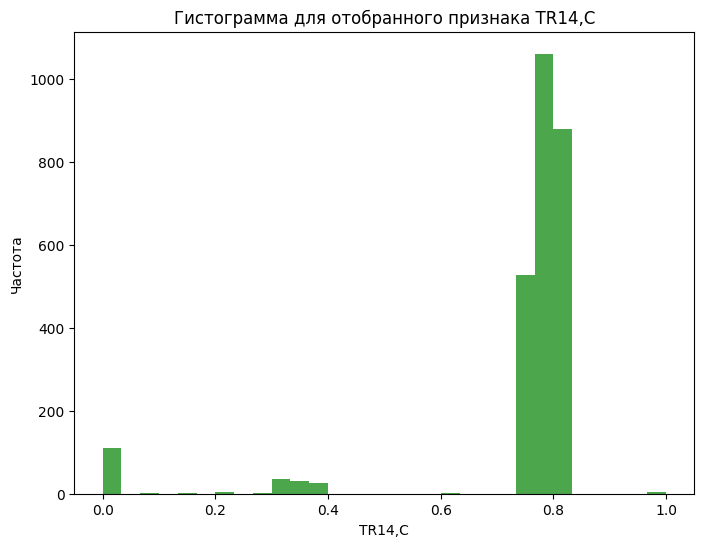

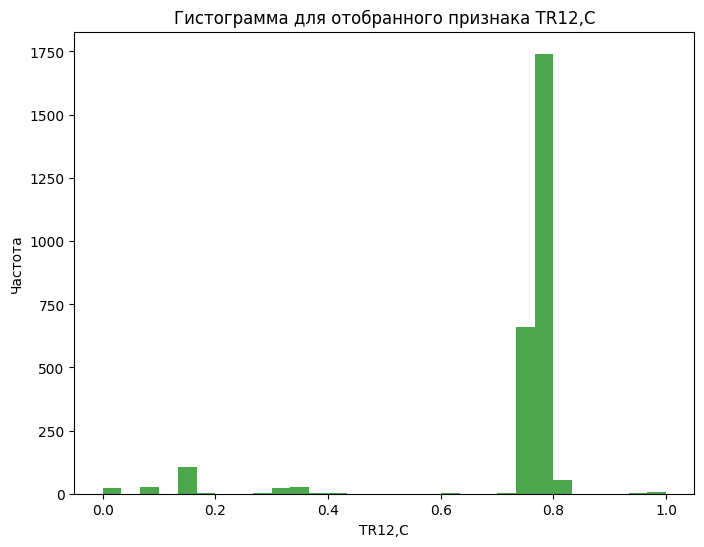

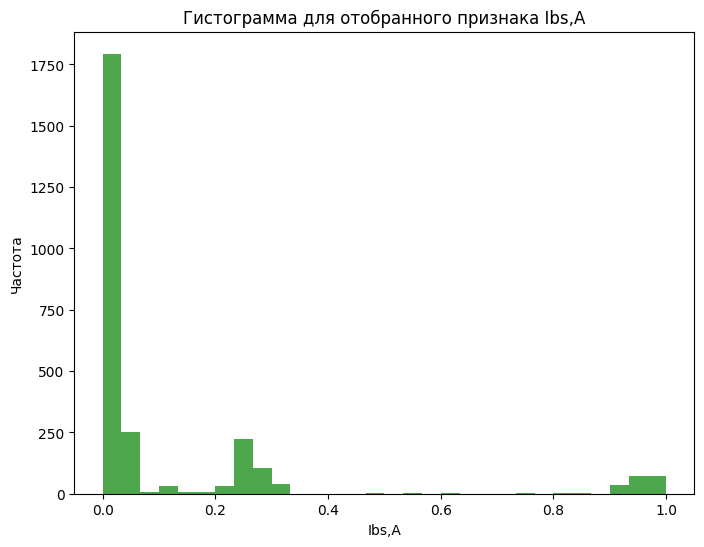

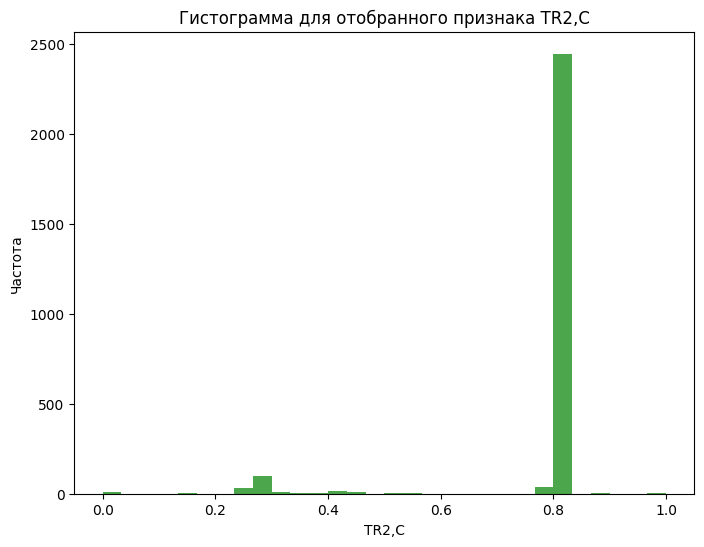

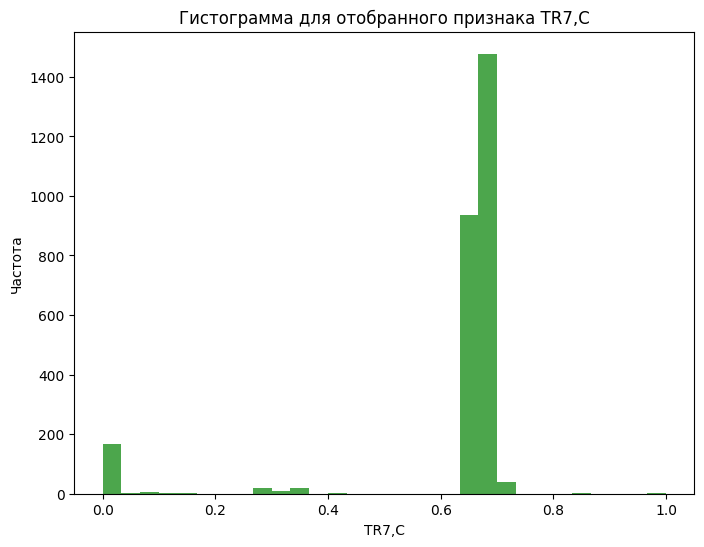


3.15.1 Графики плотности для отобранных признаков (data_transformed, первые 5):


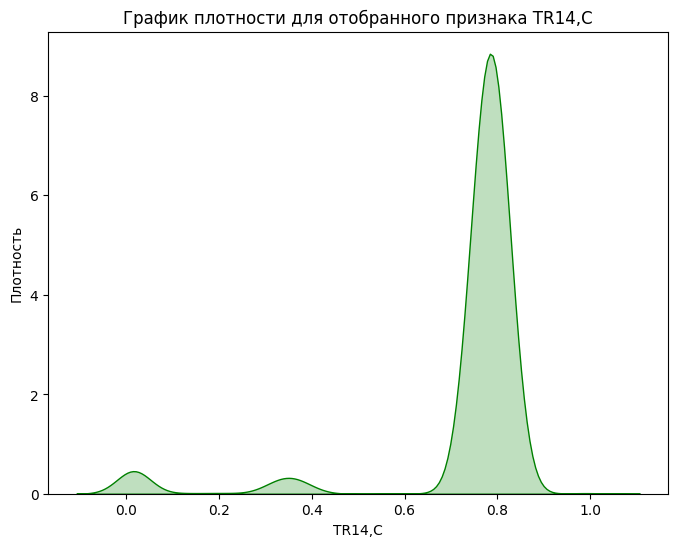

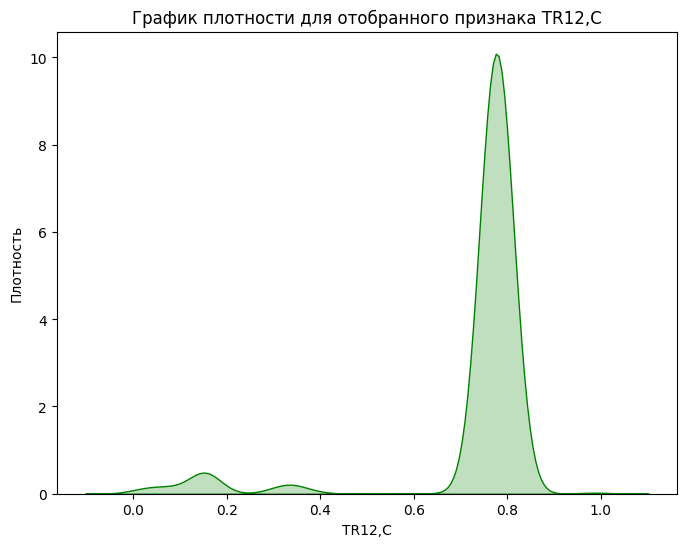

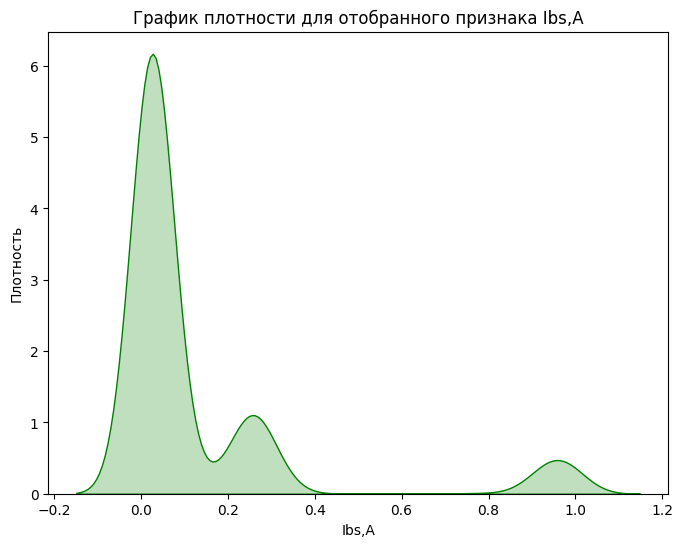

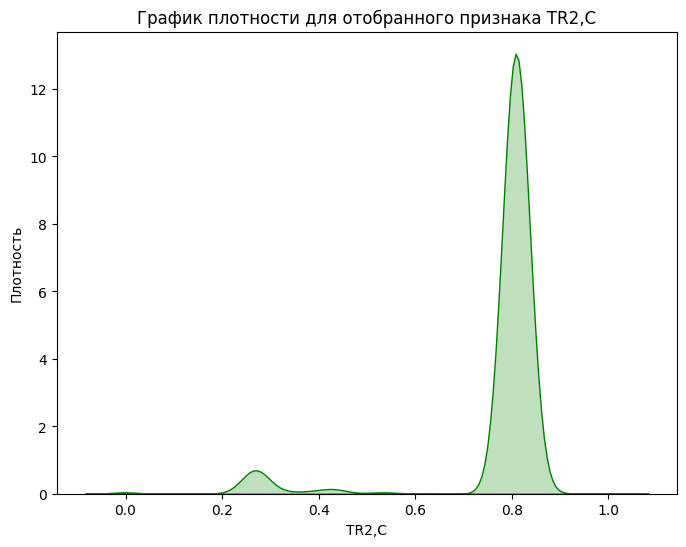

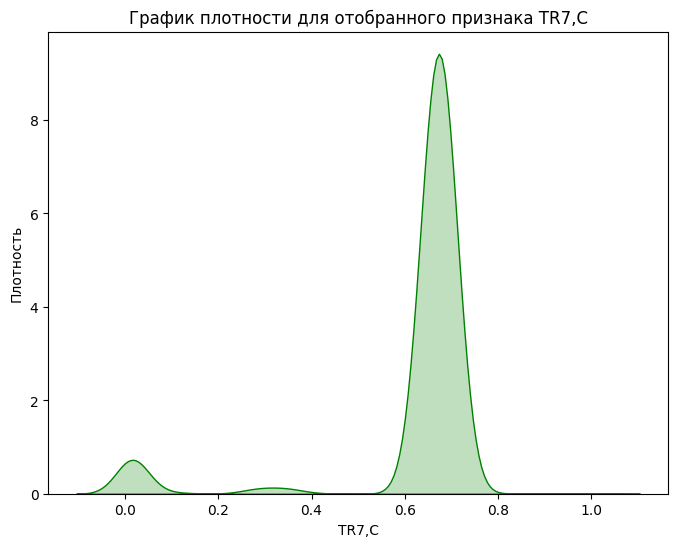


3.16. Корреляционная матрица для отобранных признаков (data_transformed):


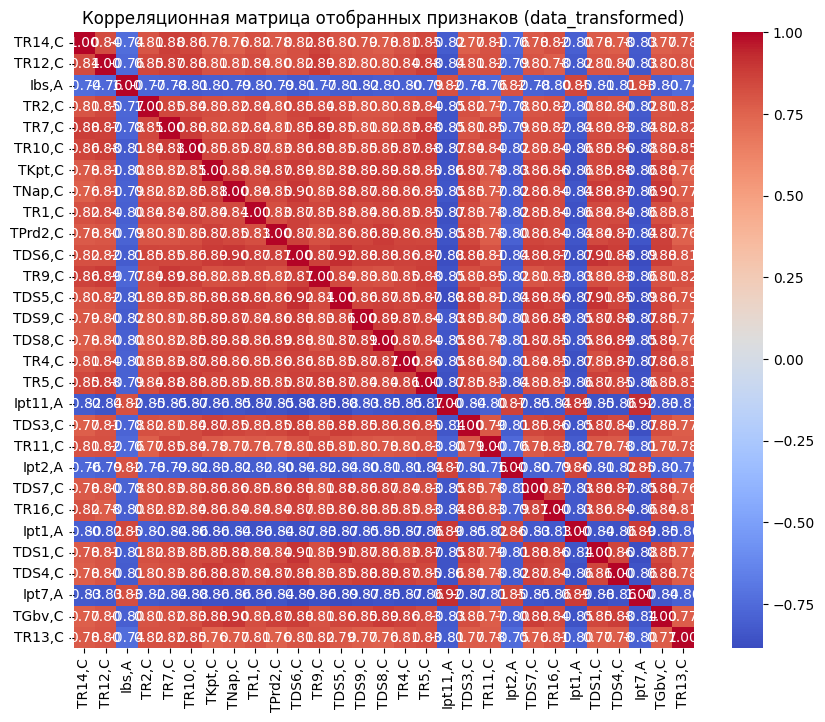


3.17.1 Матрица диаграммы рассеяния для отобранных признаков (data_transformed, первые 5):


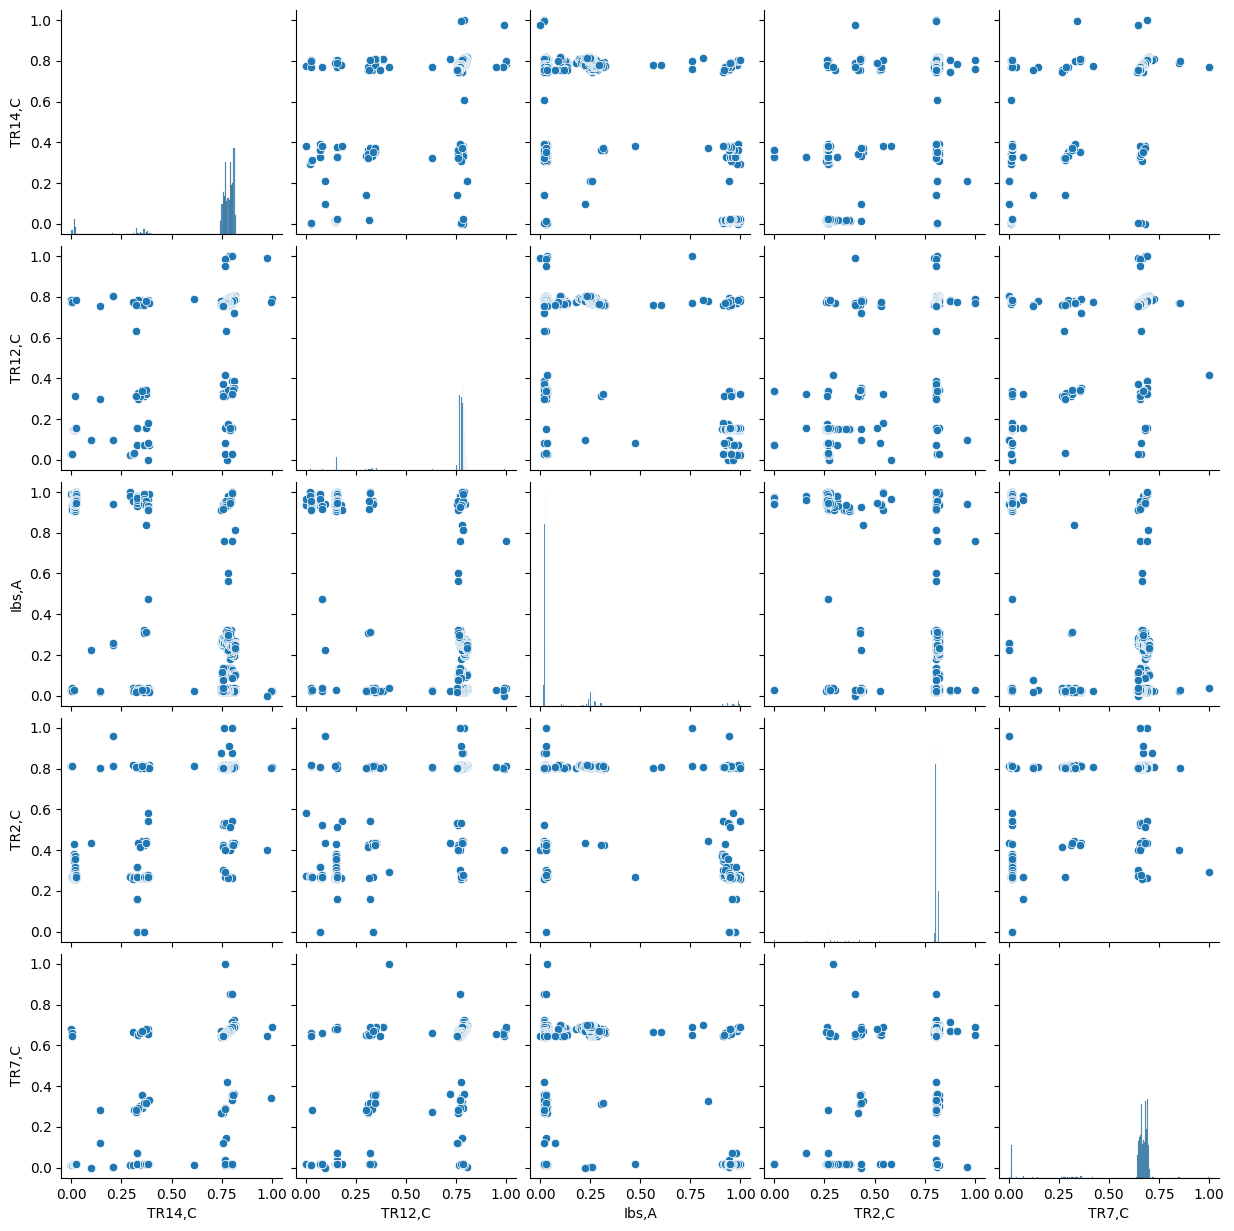

In [26]:
# 3.8. Вывод типов данных для каждой из колонок
print("\n3.8. Типы данных для каждой из колонок (data_transformed):")
print(data_transformed.dtypes)

# 3.9. Вывод первых 5 строчек для визуального осмотра преобразованных данных
print("\n3.9. Первые 5 строк преобразованного набора данных (data_transformed):")
print(data_transformed.head())

# 3.10. Вывод сводной информации о преобразованном наборе данных
print("\n3.10. Сводная информация о преобразованном наборе данных (data_transformed):")
print(data_transformed.info())

# 3.11. Вывод базовых статистических данных по отобранным признакам
print("\n3.11. Базовые статистические данные по отобранным признакам (data_transformed):")
print(data_transformed.describe())

# 3.12. Проверка на пропуски в преобразованном наборе данных
print("\n3.12. Проверка на пропуски (data_transformed):")
missing_values_transformed = data_transformed.isnull().sum()
print(missing_values_transformed[missing_values_transformed > 0])  # Только если есть
if missing_values_transformed.sum() == 0:
    print("Пропусков нет.")

# 3.13. Анализ распределения целевой переменной после балансировки
print("\nБаланс классов:")
print(data_transformed.iloc[:, -1].value_counts(normalize=True))

# 3.14.1 Гистограммы для отобранных признаков (первые 5, если признаков больше 5)
print("\n3.14.1 Гистограммы для отобранных признаков (data_transformed, первые 5):")
features_transformed = list(data_transformed.columns[:-1])  # Все кроме последнего (целевой)
features_to_plot_transformed = features_transformed[:5] if len(features_transformed) > 5 else features_transformed

for col in features_to_plot_transformed:
    plt.figure(figsize=(8, 6))
    plt.hist(data_transformed[col], bins=30, alpha=0.7, color='green')
    plt.title(f'Гистограмма для отобранного признака {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.show()

# 3.14.2 Гистограммы для всех отобранных признаков
# print("\n3.14.2 Гистограммы для всех отобранных признаков (data_transformed):")
# for col in features_transformed:
#     plt.figure(figsize=(8, 6))
#     plt.hist(data_transformed[col], bins=30, alpha=0.7, color='green')
#     plt.title(f'Гистограмма для отобранного признака {col}')
#     plt.xlabel(col)
#     plt.ylabel('Частота')
#     plt.show()

# 3.15.1 Графики плотности для отобранных признаков (первые 5)
print("\n3.15.1 Графики плотности для отобранных признаков (data_transformed, первые 5):")
for col in features_to_plot_transformed:
    plt.figure(figsize=(8, 6))
    sns.kdeplot(data_transformed[col], fill=True, color='green')
    plt.title(f'График плотности для отобранного признака {col}')
    plt.xlabel(col)
    plt.ylabel('Плотность')
    plt.show()

# 3.15.2 Графики плотности для всех отобранных признаков
# print("\n3.15.2 Графики плотности для всех отобранных признаков (data_transformed):")
# for col in features_transformed:
#     plt.figure(figsize=(8, 6))
#     sns.kdeplot(data_transformed[col], fill=True, color='green')
#     plt.title(f'График плотности для отобранного признака {col}')
#     plt.xlabel(col)
#     plt.ylabel('Плотность')
#     plt.show()

# 3.16. Многомерные графики: корреляционная матрица для отобранных признаков
print("\n3.16. Корреляционная матрица для отобранных признаков (data_transformed):")
plt.figure(figsize=(10, 8))
correlation_matrix_transformed = data_transformed.iloc[:, :-1].corr()  # Только признаки, без целевой
sns.heatmap(correlation_matrix_transformed, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица отобранных признаков (data_transformed)')
plt.show()

# 3.17.1 Матрица диаграммы рассеяния для отобранных признаков (первые 5)
print("\n3.17.1 Матрица диаграммы рассеяния для отобранных признаков (data_transformed, первые 5):")
if len(features_to_plot_transformed) > 1:
    sns.pairplot(data_transformed[features_to_plot_transformed])
    plt.show()
else:
    print("Недостаточно признаков для pairplot (нужно минимум 2)")

# 3.17.2 Матрица диаграммы рассеяния для всех отобранных признаков
# print("\n3.17.2 Матрица диаграммы рассеяния для всех отобранных признаков (data_transformed):")
# if len(features_transformed) > 1:
#     sns.pairplot(data_transformed[features_transformed])
#     plt.show()
# else:
#     print("Недостаточно признаков для pairplot (нужно минимум 2)")

Разведочный анализ преобразованного исходного набора данных (data_transformed).
1. Общая характеристика набора данных после отбора признаков:

* Размер: 2679 объектов, 30 признаков (29 отобранных параметров + 1 целевая переменная Class).
* Типы данных: Все 29 отобранных признаков представлены в числовом формате (float64), как и целевая переменная. Исходные данные были масштабированы, поэтому значения всех признаков находятся в интервале [0, 1].
* Пропуски: Пропущенных значений нет.
* Результат отбора: Набор данных является результатом стратегии "пересечение методов". 29 признаков были единогласно выбраны тремя независимыми методами (ANOVA, Mutual Information, RFE) как наиболее информативные для предсказания целевой переменной. Это высоконадежный набор признаков.

2. Анализ распределения отобранных признаков:

* Отобранные признаки можно четко разделить на две основные группы, что соответствует предметной области и подтверждает осмысленность работы методов feature selection.

2.1. Преобладающая группа:

* Признаки: TR1,C, TR2,C, TR4,C, TR5,C, TR7,C, TR9,C, TR10,C, TR11,C, TR12,C, TR13,C, TR14,C, TR16,C, TKpt,C, TNap,C, TPrd2,C, TDS3,C, TDS5,C, TDS6,C, TDS7,C, TDS8,C, TDS9,C.
* Распределения этих признаков после масштабирования сосредоточены в различных частях диапазона [0, 1], что говорит о их разной физической природе.
* Некоторые признаки (например, TR12,C, TR14,C) имеют очень узкий межквартильный размах (IQR), что указывает на стабильность их значений.
* Другие признаки (например, TKpt,C, TNap,C) демонстрируют более широкое распределение, включая экстремальные пики (значения близкие к 1.0 после масштабирования). Это характерно для параметров, которые испытывают значительные колебания в процессе работы.
* Вывод: данная группа является наиболее диагностически значимой для классификации режимов работы, что и подтвердилось их единогласным отбором всеми методами.

2.2. Асимметричные и неактивные признаки:

*  Для признаков: Ibs,A, Ipt2,A, Ipt7,A, Ipt11,A характерна сильная правосторонняя асимметрия.
* Медиана и 75-й процентиль для большинства из них равны или близки к 0.0. Это означает, что более чем в 75% наблюдений значение этих токов было нулевым или близким к нулю.
* Характерна пиковая активность: высокое среднее значение (относительно медианы) и наличие максимальных значений, близких к 1.0, указывает на редкие, но сильные всплески амплитуды значений данных параметров.
* Вывод: эти переменные большую часть времени находятся в неактивном состоянии ("спящем" режиме) и эпизодически активируются. Их наличие в финальном наборе говорит о том, что моменты активации являются высокоинформативными для различения классов.

3. Анализ целевой переменной:

* Тип: числовой (float64), представляет собой метку класса (0, 1, 2).
* Медиана: 0
* Среднее значение: ~0.16
* Диапазон: От 0.0 до 2.0
* Ключевая проблема — критический дисбаланс классов:
* * Класс 0: Является доминирующим. Количество его наблюдений (2356) составляет ~88% от всего датасета.
* * Класс 1: Является миноритарным. Количество наблюдений (218) составляет ~8%.
* * Класс 2: Является крайне миноритарным. Количество наблюдений (105) составляет ~4%.
* Вывод: нс модели будет иметь сильную склонность всегда предсказывать класс 0, так как это даст высокую (но бесполезную на практике) accuracy ~88%. Для построения качественной модели необходима обязательная балансировка классов на этапе обучения.

##### 4. Проверка набора данных на сбалансированность классов.

In [ ]:

# 4. Проверка набора данных на сбалансированность классов и оценка метрик
print("\n4. Анализ сбалансированности классов и оценка метрик")
# Определяем столбец с метками
target_column = data_original.columns[-1]

# 4.1. Подсчёт количества экземпляров по классам
class_counts = data_original[target_column].value_counts()
print("4.1. Подсчет количества экземпляров по классам:")
print(class_counts.to_string())
print(f"Общее количество примеров: {class_counts.sum()}")
print(f"Количество классов: {len(class_counts)}")

# 4.2. Статистические метрики дисбаланса
print("\n4.2. Статистические метрики дисбаланса:")
ir = class_counts.max() / class_counts.min()
print(f"Imbalance Ratio (IR): {ir:.3f} (чем выше значение, тем сильнее дисбаланс классов)")
probs = class_counts / class_counts.sum()
ent = entropy(probs)
max_ent = entropy([1/len(probs)] * len(probs))  
relative_ent = ent / max_ent if max_ent > 0 else 0
print(f"Энтропия Шеннона: {ent:.3f} (максимальная возможная: {max_ent:.3f})")
print(f"Относительная энтропия: {relative_ent:.3f} (0 - несбалансировано, 1 - идеально сбалансировано)")
gini = 1 - sum((count / class_counts.sum())**2 for count in class_counts)
print(f"Gini impurity: {gini:.3f} (0 - сбалансировано, 1 - несбалансировано)")
std_dev = np.std(probs)
print(f"Стандартное отклонение пропорций: {std_dev:.3f} (0 - сбалансировано, ~0.5 - несбалансировано)")

# 4.3. Тесты на равномерность распределения
print("\n4.3. Тесты на равномерность распределения:")
expected = [class_counts.sum() / len(class_counts)] * len(class_counts)
chi_stat, p_value = chisquare(class_counts, expected)
print(f"Хи-квадрат тест: stat={chi_stat:.3f}, p-value={p_value:.3f}")
if p_value < 0.05:
    print("Результат: Распределение НЕ равномерное (p-value < 0.05 указывает на статистически значимый дисбаланс)")
else:
    print("Результат: Распределение равномерное (p-value >= 0.05 указывает на отсутствие значимого дисбаланс)")

# 4.4. Использование библиотек и встроенных функций
print("\n4.4. Использование библиотек Python:")
classes = np.unique(data_original[target_column])
weights = compute_class_weight('balanced', classes=classes, y=data_original[target_column])
print("Веса классов (sklearn.compute_class_weight):")
for cls, weight in zip(classes, weights):
    count = class_counts[cls]
    proportion = count / class_counts.sum()
    print(f"  Класс {cls}: количество={count}, доля={proportion:.3f}, вес={weight:.3f}")
ratios = class_counts / class_counts.min()
print("\nСоотношения классов (отношение к самому маленькому классу):")
for cls, ratio in ratios.items():
    print(f"  Класс {cls}: {ratio:.3f}")

# 4.5. Classification report с основными метриками
print("4.5. Classification report с основными метриками")
y_true = data_original[target_column]
majority_class = class_counts.idxmax()
y_pred_baseline = np.full(len(y_true), majority_class)
# Accuracy
accuracy = accuracy_score(y_true, y_pred_baseline)
print(f"Accuracy: {accuracy:.4f}")
# Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_true, y_pred_baseline)
print(f"Balanced Accuracy: {balanced_acc:.4f}")
# ROC AUC Score (для многоклассовой задачи)
try:
    # Преобразуем метки в one-hot формат
    lb = LabelBinarizer()
    y_true_binarized = lb.fit_transform(y_true)
    y_pred_binarized = lb.transform(y_pred_baseline)
    
    roc_auc = roc_auc_score(y_true_binarized, y_pred_binarized, multi_class='ovr')
    print(f"ROC AUC Score: {roc_auc:.4f}")
except Exception as e:
    print(f"ROC AUC Score: невозможно вычислить ({str(e)})")
# Полный classification report
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred_baseline, 
                          target_names=[f'Class {cls}' for cls in classes],
                          zero_division=0))


# 4.6. Визуализация распределения классов
print("\n4.6. Визуализация распределения классов:")
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(class_counts)), class_counts.values)
plt.title('Распределение классов в наборе данных')
plt.xlabel('Класс')
plt.ylabel('Количество экземпляров')
# Добавляем подписи значений на столбцах
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom')
plt.xticks(range(len(class_counts)), class_counts.index)
plt.tight_layout()
plt.show()

# 4.7. Круговой график для визуализации пропорций
plt.figure(figsize=(8, 8))
plt.pie(class_counts.values, labels=[f'Class {cls}\n({count} samples)' for cls, count in class_counts.items()], 
        autopct='%1.1f%%', startangle=90)
plt.title('Процентное распределение классов')
plt.show()

В данном блоке происходит комплексный анализ дисбаланса классов в целевом наборе данных. Его основная цель — количественно оценить степень неравномерности распределения примеров по классам и спрогнозировать потенциальные проблемы, которые этот дисбаланс может вызвать при построении прогностических моделей.
Анализ проводится с помощью методов и метрик:
* Базовый подсчет (Class Counts): Прямой подсчет количества примеров в каждом классе для определения абсолютного и относительного размера классов.
* Imbalance Ratio (IR): Соотношение размера самого большого класса к самому маленькому. Показывает степень дисбаланса в простом числовом выражении.
* Энтропия Шеннона: Измеряет неопределенность в распределении. Низкая энтропия указывает на доминирование одного класса.
* Gini Impurity: Метрика, часто используемая в деревьях решений, для оценки "примеси" распределения. Значение, далекое от нуля, указывает на дисбаланс.
* Стандартное отклонение пропорций: Показывает, насколько доли классов отклоняются от среднего значения
* Статистический тест: Хи-квадрат тест проверяет нулевую гипотезу о равномерном распределении примеров по классам. Низкое p-value (< 0.05) позволяет отвергнуть эту гипотезу и статистически подтвердить наличие дисбаланса.
* Расчет весов классов: С помощью функции sklearn.compute_class_weight вычисляются веса, которые можно использовать в алгоритмах машинного обучения для компенсации дисбаланса. Эти веса обратно пропорциональны частоте класса в данных.
* Визуализация: Построение столбчатой и круговой диаграмм для интуитивно понятного восприятия пропорций между классами.

Анализ результатов: наблюдается абсолютный и относительный дисбаланс классов.

Практические последствия для моделирования: рассчитанные веса классов (например, ~4.096 для класса 1.0) показывают, во сколько раз нужно увеличить "штраф" за ошибку на примерах миноритарных классов по сравнению с ошибками на классе 0.0, чтобы алгоритм обучения обратил на них внимание.

##### 5. Подготовка и предобработка данных для обучения нейронных сетей.
В данном блоке выполняется комплексная подготовка и предобработка данных, необходимуя для корректного обучения нейронных сетей, в частности рекуррентных архитектур (RNN, LSTM, GRU). Основная цель — преобразовать "сырые" данные из двух наборов (data_original и data_transformed) в очищенный, нормализованный и структурно подходящий формат, а также разделить их на обучающую и тестовую выборки.

In [ ]:

# 5.1. Определение функции предобработки данных.
def preprocess_data(X):
    # Замена NaN и inf на 0, нормализация, StandartScaler или MinMaxScaler, 2D.
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    scaler = MinMaxScaler()
    original_shape = X.shape
    X_reshaped = X.reshape(-1, X.shape[-1])
    X_scaled = scaler.fit_transform(X_reshaped)
    X_scaled = X_scaled.reshape(original_shape)
    return X_scaled

# 5.2. Инициализация обработки датасетов.
datasets = ['data_original', 'data_transformed']
prepared_datasets = {}

# 5.3. Цикл обработки каждого датасета.
for dataset_name in datasets:
    if dataset_name == 'data_original':
        data = data_original 
    else:
        data = data_transformed 

    if hasattr(data, 'values'):
        X = data.iloc[:, :-1].values 
        y = data.iloc[:, -1].values   
    else:
        X = data[:, :-1]
        y = data[:, -1]

    # Разделение на обучающую и тестовую выборки.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Приведение к 3D-формату. Изменение формы данных с (samples, features) на (samples, features, 1).
    if len(X_train.shape) == 2:
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Нормализация обучающих, тестовых и немаркированных данных.
    X_train_normalized = preprocess_data(X_train)
    X_test_normalized = preprocess_data(X_test)
    
    if hasattr(data_unlabeled, 'values'):
        X_unlabeled = data_unlabeled.values 
    else:
        X_unlabeled = data_unlabeled
    
    if len(X_unlabeled.shape) == 2:
        X_unlabeled = X_unlabeled.reshape(X_unlabeled.shape[0], X_unlabeled.shape[1], 1)
    
    X_unlabeled_normalized = preprocess_data(X_unlabeled)
    num_classes = len(np.unique(y))  
    X_all = np.concatenate([X_train_normalized, X_test_normalized])  
    y_all = np.concatenate([y_train, y_test]) 
    
    # Сохранение наборов данных в словарь.
    prepared_datasets[dataset_name] = {
        'X_train': X_train_normalized, 'y_train': y_train, 'X_test': X_test_normalized, 'y_test': y_test,
        'X_all': X_all, 'y_all': y_all, 'num_classes': num_classes, 'X_unlabeled': X_unlabeled_normalized
    }

# 5.4. Вывода результатов.
for dataset_name in datasets:
    data = prepared_datasets[dataset_name]
    print(f"\n--- Датасет: {dataset_name} ---")
    print(f"Размерность X_train: {data['X_train'].shape}")
    print(f"Размерность X_test: {data['X_test'].shape}")
    print(f"Размерность X_unlabeled: {data['X_unlabeled'].shape}")
    print(f"Количество классов: {data['num_classes']}")
    print(f"Уникальные значения y_train: {np.unique(data['y_train'])}")
    print(f"Размерность X_all: {data['X_all'].shape}")

##### 6. Настройка генетического алгоритма для автоматического поиска оптимальной архитектуры CNN-GRU нейронной сети.
Этот блок реализует генетический алгоритм с использованием библиотеки DEAP для автоматического подбора гиперпараметров CNN-GRU модели, включая создание особей, оценку их приспособленности и эволюционный поиск оптимальной конфигурации, максимизируя точность на валидационной выборке.

Алгоритм работает по принципам эволюции:
* Создание популяции: генерируется начальный набор "особей", каждая "особь" представляет собой уникальный набор гиперпараметров.
* Оценка приспособленности: каждая особь "оценивается" путем построения и обучения соответствующей ей модели CNN-GRU. Фитнес-функцией является точность на валидационном наборе данных (val_accuracy).
* Селекция: наилучшие особи (модели с самой высокой точностью) отбираются для "размножения".
* Скрещивание (Crossover) и Мутация: отобранные особи обмениваются "генами" (гиперпараметрами), а также подвергаются случайным изменениям, чтобы создать новое, потенциально улучшенное поколение моделей.
* Замена поколений: процесс повторяется для заданного количества поколений, постепенно приближаясь к оптимальному решению.

Этапы реализации:
* Представление особи: каждая особь кодируется в виде списка из 11 гиперпараметров, определяющих архитектуру и процесс обучения модели.
* Функция построения модели (build_base_model): динамически создает модель Keras на основе переданных гиперпараметров.
* Архитектура включает: опциональные сверточные слои (Conv1D) с пулингом (MaxPooling1D), двунаправленные GRU-слои (Bidirectional(GRU)), полносвязные слои (Dense) и dropout для борьбы с переобучением.
* Модель компилируется с выбранным оптимизатором (Adam или RMSprop) и функцией потерь sparse_categorical_crossentropy.
* Функция оценки (evaluate_individual): для каждой особи декодирует гиперпараметры, строит и обучает модель на соответствующем датасете. Для ускорения процесса используется EarlyStopping (пациентность=5 эпохи), которое останавливает обучение, если точность на валидации перестает расти, и восстанавливает веса лучшей эпохи.
* Все результаты (успешные и неудачные) логируются в глобальный список all_models_log для последующего анализа.

In [ ]:

# 6.1. Регистрация (в объекте-контейнере Toolbox) классов DEAP для генетического алгоритма.
# Настраиваем все компоненты для работы ГА (FitnessMax, Individual, Операции (individual, population, mate, mutate, select)). 
if not hasattr(creator, 'FitnessMax'):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
if not hasattr(creator, 'Individual'):
    creator.create("Individual", list, fitness=creator.FitnessMax)
# Инициализация toolbox для операций с особями.
toolbox = base.Toolbox()

# 6.2. Определение функции для генерации случайных гиперпараметров для CNN-GRU архитектуры.
def define_hyperparams():
    hyperparams = {
        'num_conv_layers': random.randint(0, 3),  # Количество сверточных слоёв: 0, 1, 2 или 3
        'conv_filters': random.choice([8, 16, 32, 64]),  # Количество фильтров в свёрточных слоях
        'kernel_size': random.choice([3, 5, 7]),  # Размер ядра свёртки
        'pool_size': random.choice([2, 3]),  # Размер пулинга
        'gru_units': random.choice([32, 64, 128, 256]),  # Количество GRU юнитов
        'num_gru_layers': random.randint(1, 3),  # Количество GRU слоёв: 1, 2 или 3
        'dense_units': random.randint(64, 256),  # Количество нейронов в плотном слое
        'dropout_rate': random.uniform(0.0, 0.5),  # Скорость dropout
        'learning_rate': random.uniform(0.0001, 0.01),  # Скорость обучения
        'optimizer': random.choice(['adam', 'rmsprop']),  # Оптимизатор
        'batch_size': random.randint(16, 128)  # Размер батча
    }
    return hyperparams

# 6.3. Определение функции построения базовой CNN-GRU модели.
def build_base_model(input_shape, num_classes, hyperparams):
   
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    
    # Блок сверточных слоев (CNN).
    num_conv_layers = hyperparams['num_conv_layers']
    for i in range(num_conv_layers):
        model.add(layers.Conv1D(
            filters=hyperparams['conv_filters'],  # Количество фильтров
            kernel_size=hyperparams['kernel_size'],  # Размер ядра
            activation='relu',  # Функция активации
            padding='same',  # Сохранение размерности
            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),  # L1-L2 регуляризация
            name=f'conv_{i+1}'  
        ))
        # Добавление MaxPooling после каждого сверточного слоя, кроме последнего.
        if i < num_conv_layers - 1: 
            model.add(layers.MaxPooling1D(
                pool_size=hyperparams['pool_size'], 
                name=f'pool_{i+1}' 
            ))

    # Блок рекуррентных слоев (Bidirectional GRU).
    for i in range(hyperparams['num_gru_layers']):
        is_last_layer = i == hyperparams['num_gru_layers'] - 1
        model.add(layers.Bidirectional(layers.GRU(
            units=hyperparams['gru_units'],  # Количество GRU юнитов
            return_sequences=not is_last_layer,  # Возврат последовательности только если не последний слой
            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),  # Регуляризация ядра
            recurrent_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),  # Регуляризация рекуррентных весов
            name=f'gru_{i+1}'  
        )))
        model.add(layers.Dropout(hyperparams['dropout_rate']))  # Dropout для борьбы с переобучением
    
    # Блок полносвязных слоев (Dense).
    model.add(layers.Dense(hyperparams['dense_units'], activation='relu'))  # Полносвязный слой
    model.add(layers.Dropout(hyperparams['dropout_rate']))  # Dropout регуляризация
    
    # Выходной слой с softmax.
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    # Компиляция модели с выбранным оптимизатором.
    if hyperparams['optimizer'] == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=hyperparams['learning_rate'])
    else:
        opt = tf.keras.optimizers.RMSprop(learning_rate=hyperparams['learning_rate'])
    
    model.compile(optimizer=opt, 
                  loss='sparse_categorical_crossentropy',  # Для целочисленных меток
                  metrics=['accuracy'])
    return model


# 6.4. Определение функции оценки особи.
# Берем особь (набор гиперпараметров), строим по ним модель, обучаем ее на короткой сессии (20 эпох)
# возвращаем ее точность на валидации как меру приспособленности этой особи. Логгируем результаты.
def evaluate_individual(individual, dataset_name):
    hyperparams = {
        'num_conv_layers': int(individual[0]),
        'conv_filters': int(individual[1]),
        'kernel_size': int(individual[2]),
        'pool_size': int(individual[3]),
        'gru_units': int(individual[4]),
        'num_gru_layers': int(individual[5]),
        'dense_units': int(individual[6]),
        'dropout_rate': individual[7],
        'learning_rate': individual[8],
        'optimizer': individual[9],
        'batch_size': int(individual[10])
    }
    
    try:
        input_shape = (prepared_datasets[dataset_name]['X_train'].shape[1], 
                      prepared_datasets[dataset_name]['X_train'].shape[2])
        num_classes = prepared_datasets[dataset_name]['num_classes']
        
        model = build_base_model(input_shape, num_classes, hyperparams)
        
        history = model.fit(prepared_datasets[dataset_name]['X_train'], 
                           prepared_datasets[dataset_name]['y_train'],
                           epochs=20, 
                           batch_size=hyperparams['batch_size'], 
                           validation_split=0.2, 
                           callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                                      patience=5, 
                                                                      restore_best_weights=True)], 
                           verbose=0)
        
        val_accuracy = history.history['val_accuracy'][-1]
        
        log_entry = {
            "dataset": dataset_name, 
            "hyperparams": hyperparams, 
            "val_accuracy": val_accuracy, 
            "error": None
        }
        all_models_log.append(log_entry)
        return (val_accuracy,)
    except Exception as e:
        val_accuracy = 0.0
        log_entry = {
            "dataset": dataset_name, 
            "hyperparams": hyperparams, 
            "val_accuracy": val_accuracy, 
            "error": str(e)
        }
        all_models_log.append(log_entry)
        return (val_accuracy,)

# 6.5. Регистрация операций DEAP для генетического алгоритма.
# Настраиваем "правила эволюции" для алгоритма: оздание особей, скрещивание (mate), мутация (mutate) и отбор лучших (select).
def create_individual():
    hyperparams = define_hyperparams()
    return [
        hyperparams['num_conv_layers'],
        hyperparams['conv_filters'],
        hyperparams['kernel_size'],
        hyperparams['pool_size'],
        hyperparams['gru_units'],
        hyperparams['num_gru_layers'],
        hyperparams['dense_units'],
        hyperparams['dropout_rate'],
        hyperparams['learning_rate'],
        hyperparams['optimizer'],
        hyperparams['batch_size']
    ]

toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_individual)
toolbox.register("mate", tools.cxTwoPoint)  
toolbox.register("mutate", tools.mutUniformInt, low=0, up=100, indpb=0.2) 
toolbox.register("select", tools.selTournament, tournsize=3) 

# 6.6. Запуск генетического алгоритма для каждого датасета.
# Создаем начальную популяцию случайных моделей и запускаем процесс ГА (скрещивание, мутация, отбор).
best_hyperparams_per_dataset = {}
all_models_log = []
POPULATION_SIZE = 12
NUM_GENERATIONS = 6

def print_generation_stats(generation, population, dataset_name):
    fitnesses = [ind.fitness.values[0] for ind in population]
    best_fitness = max(fitnesses)
    avg_fitness = sum(fitnesses) / len(fitnesses)
    print(f"Датасет: {dataset_name} | Поколение: {generation}")
    print(f"Лучшая точность: {best_fitness:.4f} | Средняя точность: {avg_fitness:.4f}")
    print(f"Диапазон точности: {min(fitnesses):.4f} - {max(fitnesses):.4f}")
    print("-" * 50)

for dataset_name in datasets:
    # Создаем функцию оценки датасета.
    def evaluate_for_dataset(individual):
        return evaluate_individual(individual, dataset_name)

    toolbox.register("evaluate", evaluate_for_dataset)
    population = toolbox.population(n=POPULATION_SIZE)
    
    # Оцениваем начальную популяцию.
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit
    print_generation_stats(0, population, dataset_name)
    
    # Эволюционный процесс
    for gen in range(1, NUM_GENERATIONS + 1):
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
        
        # Оцениваем новых особей.
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
            
        # Отбираем следующее поколение.
        population = toolbox.select(offspring, k=len(population))
        print_generation_stats(gen, population, dataset_name)
    
    # Находим лучшую особь.
    best_individual = tools.selBest(population, 1)[0]
    best_hyperparams = {
        'num_conv_layers': int(best_individual[0]),
        'conv_filters': int(best_individual[1]),
        'kernel_size': int(best_individual[2]),
        'pool_size': int(best_individual[3]),
        'gru_units': int(best_individual[4]),
        'num_gru_layers': int(best_individual[5]),
        'dense_units': int(best_individual[6]),
        'dropout_rate': best_individual[7],
        'learning_rate': best_individual[8],
        'optimizer': best_individual[9],
        'batch_size': int(best_individual[10]),
        'best_accuracy': best_individual.fitness.values[0]
    }
    
    print(f"\nЛучшие гиперпараметры для {dataset_name}:")
    for key, value in best_hyperparams.items():
        print(f"  {key}: {value}")
    print(f"  Validation Accuracy: {best_individual.fitness.values[0]:.4f}")
    print("\n")
    
    best_hyperparams_per_dataset[dataset_name] = best_hyperparams

print("Итоги подбора гиперпараметров:")
for dataset_name, params in best_hyperparams_per_dataset.items():
    print(f"\nДатасет: {dataset_name}")
    print(f"Точность: {params['best_accuracy']:.4f}")
    print("Параметры:")
    for key, value in params.items():
        if key != 'best_accuracy':
            print(f"  {key}: {value}")

Результат:

Задаются параметры эволюции:
* Размер популяции: 12 особей.
* Количество поколений: 6.
* Вероятности: Скрещивания (cxpb) — 50%, мутации (mutpb) — 20%.
* Методы отбора: Турнирный отбор (selTournament) с размером турнира 3, двухточечное скрещивание (cxTwoPoint), равномерная мутация (mutUniformInt).

Результат работы алгоритма:
* Для данных с исходным пространством признаков (data_original) лучший результат (96.97%) был достигнут с помощью более глубокой и сложной модели, требующей сильной регуляризации.
* Для данных с уменьшенным пространством признаков (data_transformed) лучший результат (96.27%) был достигнут с помощью более простой и легкой модели.

Таким образом, при почти схожем результате модели (погрешность ~1%), преобразованный набор в 1.7 раз меньше, с более простой моделью эффективнее при ограниченных ресурсах.

##### 7. Финальное обучение и оценка лучших моделей для каждого датасета с выбором оптимальной конфигурации.
Этот блок выполняет финальное обучение моделей с лучшими найденными гиперпараметрами на полных данных, оценивает их производительность на тестовых выборках и выбирает лучшую модель среди всех датасетов.

Этапы реализации:
* Финальное обучение на полных данных: использование всего доступного тренировочного набора данных (X_all, y_all) для максимального обучения модели, а не только части для валидации.
* Объективная оценка на тестовых данных: проверка реальной производительности модели на абсолютно новых, ранее не использовавшихся данных (X_test, y_test).
* Сравнение и выбор чемпиона: определение датасета и соответствующей ему модели, которые показывают наилучшую обобщающую способность (наивысшую точность на тестовом наборе).
* Сохранение лучшей модели: экспорт оптимальной модели в файл для последующего развертывания и использования.

In [ ]:

# 7.1. Инициализация словарей для хранения финальных моделей и их точности.
final_models_per_dataset = {} # обученные модели (объектов Keras Model) для каждого датасета.
best_accuracy_per_dataset = {} # итоговая точность каждой модели на тестовой выборке.

# 7.2. Цикл финального обучения и оценки для каждого датасета.
for dataset_name in datasets:
    # Извлечение лучших гиперпараметров, найденных генетическим алгоритмом.
    hyperparams = best_hyperparams_per_dataset[dataset_name]
    
    # Определение формы входных данных и количества классов.
    input_shape = (prepared_datasets[dataset_name]['X_all'].shape[1], 
                  prepared_datasets[dataset_name]['X_all'].shape[2])
    num_classes = prepared_datasets[dataset_name]['num_classes']
    
    # Построение модели с этими гиперпараметрами.
    model = build_base_model(input_shape, num_classes, hyperparams)
    
    # Обучение модели на ВСЕХ размеченных данных (не только на тренировочных).
    history = model.fit(prepared_datasets[dataset_name]['X_all'], 
                       prepared_datasets[dataset_name]['y_all'],
                       epochs=30, 
                       batch_size=hyperparams['batch_size'], 
                       callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', 
                                                                  patience=10, 
                                                                  restore_best_weights=True)], 
                       verbose=1)
    
    # Оценка точности обученной модели на тестовой выборке.
    accuracy = model.evaluate(prepared_datasets[dataset_name]['X_test'], 
                             prepared_datasets[dataset_name]['y_test'], 
                             verbose=0)[1]
    
    # Сохранение полученной модели и ее точности.
    best_accuracy_per_dataset[dataset_name] = accuracy
    final_models_per_dataset[dataset_name] = model

# Выбор лучшей модели среди всех датасетов (по максимальной точности).
best_dataset = max(best_accuracy_per_dataset, key=best_accuracy_per_dataset.get)
best_model = final_models_per_dataset[best_dataset]
best_data = prepared_datasets[best_dataset]
best_hyperparams = best_hyperparams_per_dataset[best_dataset]

# 7.3. Сохранение лучшей модели в файл
try:
    best_model.save(f'base_model_{best_dataset}.keras')
    print(f"Базовая модель сохранена как base_model_{best_dataset}.keras")
except:
    best_model.save(f'base_model_{best_dataset}.h5')
    print(f"Базовая модель сохранена как base_model_{best_dataset}.h5")


##### 8. Построение автокодировщика на основе лучшей CNN-GRU архитектуры.
Этот блок создает и обучает автокодировщик, который использует структуру энкодера, повторяющую архитектуру лучшей найденной CNN-GRU модели, и симметричный ей декодер для реконструкции временных рядов.

Этапы реализации:
* Использование лучшей конфигурации гиперпараметров, для построения энкодера.
* Построение декодера, который зеркально повторяет слои энкодера, но использует операции UpSampling для восстановления исходной временной последовательности из сжатого латентного представления.
* Использование большого объема неразмеченных данных (X_unlabeled) для обучения модели в режиме реконструкции. Модель учится сжимать входные данные в компактное представление и затем максимально точно восстанавливать их из этого представления.
* В результате обучения автокодировщика создается энкодер, который будет использован на следующем этапе для извлечения признаков и дообучения на размеченных данных.

In [ ]:

# 8.1. Реализация функции построения автокодировщика и энкодера.
def build_autoencoder(input_shape, hyperparams):
    
    # Создание симметричной архитектуры автокодировщика.
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    
    # Построение энкодера по структуре лучшей найденной CNN-GRU модели.
    num_conv_layers = hyperparams['num_conv_layers']
    for i in range(num_conv_layers):
        x = layers.Conv1D(
            filters=hyperparams['conv_filters'],
            kernel_size=hyperparams['kernel_size'],
            activation='relu',
            padding='same',
            name=f'encoder_conv_{i+1}'
        )(x)
        if i < num_conv_layers - 1:
            x = layers.MaxPooling1D(
                pool_size=hyperparams['pool_size'],
                name=f'encoder_pool_{i+1}'
            )(x)
    
    for i in range(hyperparams['num_gru_layers']):
        is_last_layer = i == hyperparams['num_gru_layers'] - 1
        x = layers.Bidirectional(layers.GRU(
            units=hyperparams['gru_units'],
            return_sequences=not is_last_layer,
            name=f'encoder_gru_{i+1}'
        ))(x)
        x = layers.Dropout(hyperparams['dropout_rate'])(x)
    
    # Генерирование скрытого представления (latent representation) данных.
    latent_representation = x
    encoder = tf.keras.Model(inputs, latent_representation, name='encoder')
    
    # Построение декодера зеркально энкодеру.
    decoded = latent_representation
    
    if hyperparams['num_gru_layers'] > 1:
        decoded = layers.RepeatVector(input_shape[0])(decoded)

    for i in range(hyperparams['num_gru_layers']):
        decoded = layers.Bidirectional(layers.GRU(
            units=hyperparams['gru_units'],
            return_sequences=True,
            name=f'decoder_gru_{i+1}'
        ))(decoded)
        decoded = layers.Dropout(hyperparams['dropout_rate'])(decoded)
    
    for i in range(num_conv_layers):
        decoded = layers.Conv1D(
            filters=hyperparams['conv_filters'],
            kernel_size=hyperparams['kernel_size'],
            activation='relu',
            padding='same',
            name=f'decoder_conv_{i+1}'
        )(decoded)
        if i < num_conv_layers - 1:
            decoded = layers.UpSampling1D(
                size=hyperparams['pool_size'],
                name=f'decoder_upsample_{i+1}'
            )(decoded)
    
    outputs = layers.Conv1D(
        filters=input_shape[-1],
        kernel_size=hyperparams['kernel_size'],
        activation='sigmoid',
        padding='same',
        name='decoder_output'
    )(decoded)
    
    # Компилирование модели с оптимизатором Adam и функцией потерь MSE.
    autoencoder = tf.keras.Model(inputs, outputs, name='autoencoder')
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return encoder, autoencoder

# 8.2. Обучение автокодировщика на неразмеченных данных.
X_unlabeled = best_data['X_unlabeled']
input_shape = (best_data['X_all'].shape[1], best_data['X_all'].shape[2])
encoder, autoencoder = build_autoencoder(input_shape, best_hyperparams)
autoencoder.fit(
    X_unlabeled, X_unlabeled,
    epochs=2,
    batch_size=best_hyperparams['batch_size'],
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='loss', patience=10, restore_best_weights=True
    )],
    verbose=1
)
print("Автокодировщик обучен.")

##### 9. Создание ансамбля бэггинг на основе предобученного автокодировщика.
Этот блок реализует двухэтапную точную настройку предобученного энкодера и создает ансамбль моделей методом бэггинга
для дальнейшего улучшения качества классификации.

Этапы реализации:
* Реализация двухэтапного процесса обучения, где сначала обучаются только классификационные слои при замороженных весах энкодера, а затем производится дообучение верхних слоев энкодера вместе с классификатором.
* Построение нескольких независимых моделей на основе бэггинга (bootstrap aggregating), где каждая модель обучается на своей бутстрап-выборке из исходных данных для повышения стабильности и обобщающей способности.
* Усреднение вероятностных предсказаний всех моделей ансамбля для получения финального, более надежного результата классификации.
* Оценка и сравнение точности исходной модели, модели после точной настройки и итогового ансамбля для демонстрации прогресса в улучшении качества классификации.

In [ ]:

# 9.1. Функция для создания модели и дообучения ее на основе предобученного энкодера.
def create_fine_tune_model(encoder, input_shape, num_classes, best_hyperparams):
    # Замораживание весов энкодера для предотвращения их изменения на первом этапе обучения.
    encoder.trainable = False

    # Создание модели с предобученным энкодером.
    inputs = tf.keras.Input(shape=input_shape)
    x = encoder(inputs) 
    
    # Добавление дополнительных плотных слоев для классификации.
    x = layers.Dense(best_hyperparams['dense_units'], activation='relu')(x)
    x = layers.Dropout(best_hyperparams['dropout_rate'])(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    # Создание конечной модели.
    model = tf.keras.Model(inputs, outputs)
    
    # Компиляция модели и ее обучение.
    if best_hyperparams['optimizer'] == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=best_hyperparams['learning_rate'] * 0.1)
    else:
        opt = tf.keras.optimizers.RMSprop(learning_rate=best_hyperparams['learning_rate'] * 0.1)
    
    model.compile(optimizer=opt, 
                 loss='sparse_categorical_crossentropy', 
                 metrics=['accuracy'])
    
    return model

# 9.2. Двухэтапное обучение модели (реализация функции из 9.1).
fine_tune_model = create_fine_tune_model(
    encoder, input_shape, best_data['num_classes'], best_hyperparams
)
# Обучение только классификационных слоев при замороженном энкодере.
history_phase1 = fine_tune_model.fit(
    best_data['X_all'], best_data['y_all'],
    epochs=4,
    batch_size=best_hyperparams['batch_size'],
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=5, restore_best_weights=True
    )],
    verbose=1
)

# Разморозка последних слоев энкодера и дообучение всей модели.
for layer in encoder.layers[-4:]: 
    layer.trainable = True

if best_hyperparams['optimizer'] == 'adam':
    opt = tf.keras.optimizers.Adam(learning_rate=best_hyperparams['learning_rate'] * 0.01)
else:
    opt = tf.keras.optimizers.RMSprop(learning_rate=best_hyperparams['learning_rate'] * 0.01)

fine_tune_model.compile(optimizer=opt, 
                       loss='sparse_categorical_crossentropy', 
                       metrics=['accuracy'])

history_phase2 = fine_tune_model.fit(
    best_data['X_all'], best_data['y_all'],
    epochs=4,
    batch_size=best_hyperparams['batch_size'],
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=10, restore_best_weights=True
    )],
    verbose=1
)
final_accuracy = fine_tune_model.evaluate(
    best_data['X_test'], best_data['y_test'], verbose=0
)[1]
print(f"Финальная точность после дообучения: {final_accuracy:.4f}")

# 9.3. Реализация функций для создания ансамбля бэггинг
def create_bagging_ensemble(encoder, input_shape, num_classes, best_hyperparams, n_models=5):
    models = []
    
    # Создание нескольких моделей на основе бутстрап-выборок.
    for i in range(n_models):
        model = create_fine_tune_model(encoder, input_shape, num_classes, best_hyperparams)

        # Создание бутстрап-выборки с повторениями
        indices = np.random.choice(len(best_data['X_all']), len(best_data['X_all']), replace=True)
        X_bootstrap = best_data['X_all'][indices]
        y_bootstrap = best_data['y_all'][indices]
        
        # Обучение каждой модели на своем подмножестве данных.
        model.fit(
            X_bootstrap, y_bootstrap,
            epochs=4,
            batch_size=best_hyperparams['batch_size'],
            callbacks=[tf.keras.callbacks.EarlyStopping(
                monitor='accuracy', patience=5, restore_best_weights=True
            )],
            verbose=0
        )
        
        models.append(model)
    
    return models

def ensemble_predict(models, X):
    # Агрегация предсказаний методом усреднения.
    predictions = np.zeros((X.shape[0], models[0].output_shape[1]))
    for model in models:
        pred = model.predict(X, verbose=0)
        predictions += pred
    return predictions / len(models)


# 9.4. Создание и оценка ансамбля бэггинг
ensemble_models = create_bagging_ensemble(
    encoder, input_shape, best_data['num_classes'], best_hyperparams, n_models=5
)
ensemble_probs = ensemble_predict(ensemble_models, best_data['X_test'])
ensemble_preds = np.argmax(ensemble_probs, axis=1)
ensemble_accuracy = np.mean(ensemble_preds == best_data['y_test'])
print(f"Точность ансамбля бэггинг: {ensemble_accuracy:.4f}")
print(f"Точность исходной модели: {best_accuracy_per_dataset[best_dataset]:.4f}")
print(f"Точность после fine-tuning: {final_accuracy:.4f}")
print(f"Точность ансамбля: {ensemble_accuracy:.4f}")